In [12]:
# /data/label_fusion/
# │
# ├── test_deepseekv32_on_local_data_results_labeled.csv
# ├── test_gemini25flash_on_local_data_results_labeled.csv
# ├── test_gemma34b_on_local_data_results_labeled.csv
# ├── test_gemma34b_on_webcrawler_data_results_labeled.csv
# ├── test_llama318b_on_harmful_prompts_results_labeled.csv
# ├── test_llama318b_on_local_data_results_labeled.csv
# ├── test_llama318b_on_webcrawler_data_results_labeled.csv
# ├── test_qwen34b_on_harmful_prompts_results_labeled.csv
# ├── test_qwen34b_on_local_data_results_labeled.csv
# └── test_qwen34b_on_webcrawler_data_results_labeled.csv

# Overall
Global Over-refusal Pipeline

In [39]:
import os
import pandas as pd
import plotly.graph_objects as go

def plot_compact_sankey():
    model_csv_dict = {
        "Llama 3.1 8B (Local)": "../data/label_fusion/test_llama318b_on_local_data_results_labeled.csv",
        "Llama 3.1 8B (Webcrawler)": "../data/label_fusion/test_llama318b_on_webcrawler_data_results_labeled.csv",
        "Llama 3.1 8B (Harmful)": "../data/label_fusion/test_llama318b_on_harmful_prompts_results_labeled.csv",

        "Qwen 3-4B (Local)": "../data/label_fusion/test_qwen34b_on_local_data_results_labeled.csv",
        "Qwen 3-4B (Webcrawler)": "../data/label_fusion/test_qwen34b_on_webcrawler_data_results_labeled.csv",
        "Qwen 3-4B (Harmful)": "../data/label_fusion/test_qwen34b_on_harmful_prompts_results_labeled.csv",

        "Gemma 3-4B (Local)": "../data/label_fusion/test_gemma34b_on_local_data_results_labeled.csv",
        "Gemma 3-4B (Webcrawler)": "../data/label_fusion/test_gemma34b_on_webcrawler_data_results_labeled.csv",

        "Gemini 2.5 Flash (Local)": "../data/label_fusion/test_gemini25flash_on_local_data_results_labeled.csv",
        "DeepSeek V3.2 (Local)": "../data/label_fusion/test_deepseekv32_on_local_data_results_labeled.csv"
    }

    lang_cols = {
        "English": "Final_Label_EN",
        "Chinese": "Final_Label_CN",
        "Mixed": "Final_Label_MIX"
    }

    all_data = []
    for model_name, path in model_csv_dict.items():
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path)
        for lang, col in lang_cols.items():
            if col in df.columns:
                tmp = df[["Category", "Rewrite Method", col]].copy()
                tmp.rename(columns={col: "Label"}, inplace=True)
                tmp["Language"] = lang
                tmp["Model"] = model_name.split(" (")[0]
                tmp["DataSource"] = model_name.split(" (")[1].replace(")", "")
                all_data.append(tmp)

    df_long = pd.concat(all_data, ignore_index=True)

    df_long["Label"] = (
        df_long["Label"].astype(str).str.lower().map({
            "answer": "Answer",
            "refuse": "Refuse",
            "拒绝": "Refuse",
            "回答": "Answer"
        }).fillna("Answer")
    )

    flows = (
        df_long.groupby(["Model", "DataSource", "Category", "Rewrite Method", "Language", "Label"])
        .size()
        .reset_index(name="Count")
    )

    models = flows["Model"].unique().tolist()
    sourceset = flows["DataSource"].unique().tolist()
    categories = flows["Category"].unique().tolist()
    methods = flows["Rewrite Method"].unique().tolist()
    langs = ["English", "Chinese", "Mixed"]
    labels = ["Answer", "Refuse"]

    nodes = models + sourceset + categories + methods + langs + labels
    node_idx = {name: i for i, name in enumerate(nodes)}

    def add_links(df, src_col, tgt_col):
        srcs, tgts, vals = [], [], []
        for _, r in df.groupby([src_col, tgt_col])["Count"].sum().reset_index().iterrows():
            srcs.append(node_idx[r[src_col]])
            tgts.append(node_idx[r[tgt_col]])
            vals.append(r["Count"])
        return srcs, tgts, vals

    sources, targets, values = [], [], []
    for s, t in [("Model", "DataSource"), ("DataSource", "Category"),
                 ("Category", "Rewrite Method"), ("Rewrite Method", "Language"),
                 ("Language", "Label")]:
        s2, t2, v2 = add_links(flows, s, t)
        sources += s2
        targets += t2
        values += v2

    fig = go.Figure(data=[go.Sankey(
        arrangement="snap",
        node=dict(
            pad=6,                
            thickness=10,         
            line=dict(color="black", width=0.3),
            label=nodes,
            color=(
                ["#4F81BD"] * len(models)
                + ["#9BBB59"] * len(sourceset)
                + ["#C0504D"] * len(categories)
                + ["#F79646"] * len(methods)
                + ["#8064A2", "#BEBEBE", "#92D050"]
                + ["#2ECC71", "#E74C3C"]
            ),
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color="rgba(150,150,150,0.25)",
            hovertemplate="%{source.label} → %{target.label}<br>%{value} samples<extra></extra>"
        )
    )])

    fig.update_layout(
        title_text="Compact Global Over-Refusal Flow — Model → Data Source → Category → Rewrite Method → Language → Label",
        font=dict(size=9, color="black"),
        height=620,    
        width=900,    
        margin=dict(l=20, r=20, t=50, b=20)
    )

    fig.show()

plot_compact_sankey()

# Local Data

Bar charts comprehensively display the influence ranking of a certain indicator among mainstream LLMs.  
Heatmaps intuitively and in more detail show the different sensitivities of LLMs to a certain indicator.

## OR by Category

Rader Diagram in V13

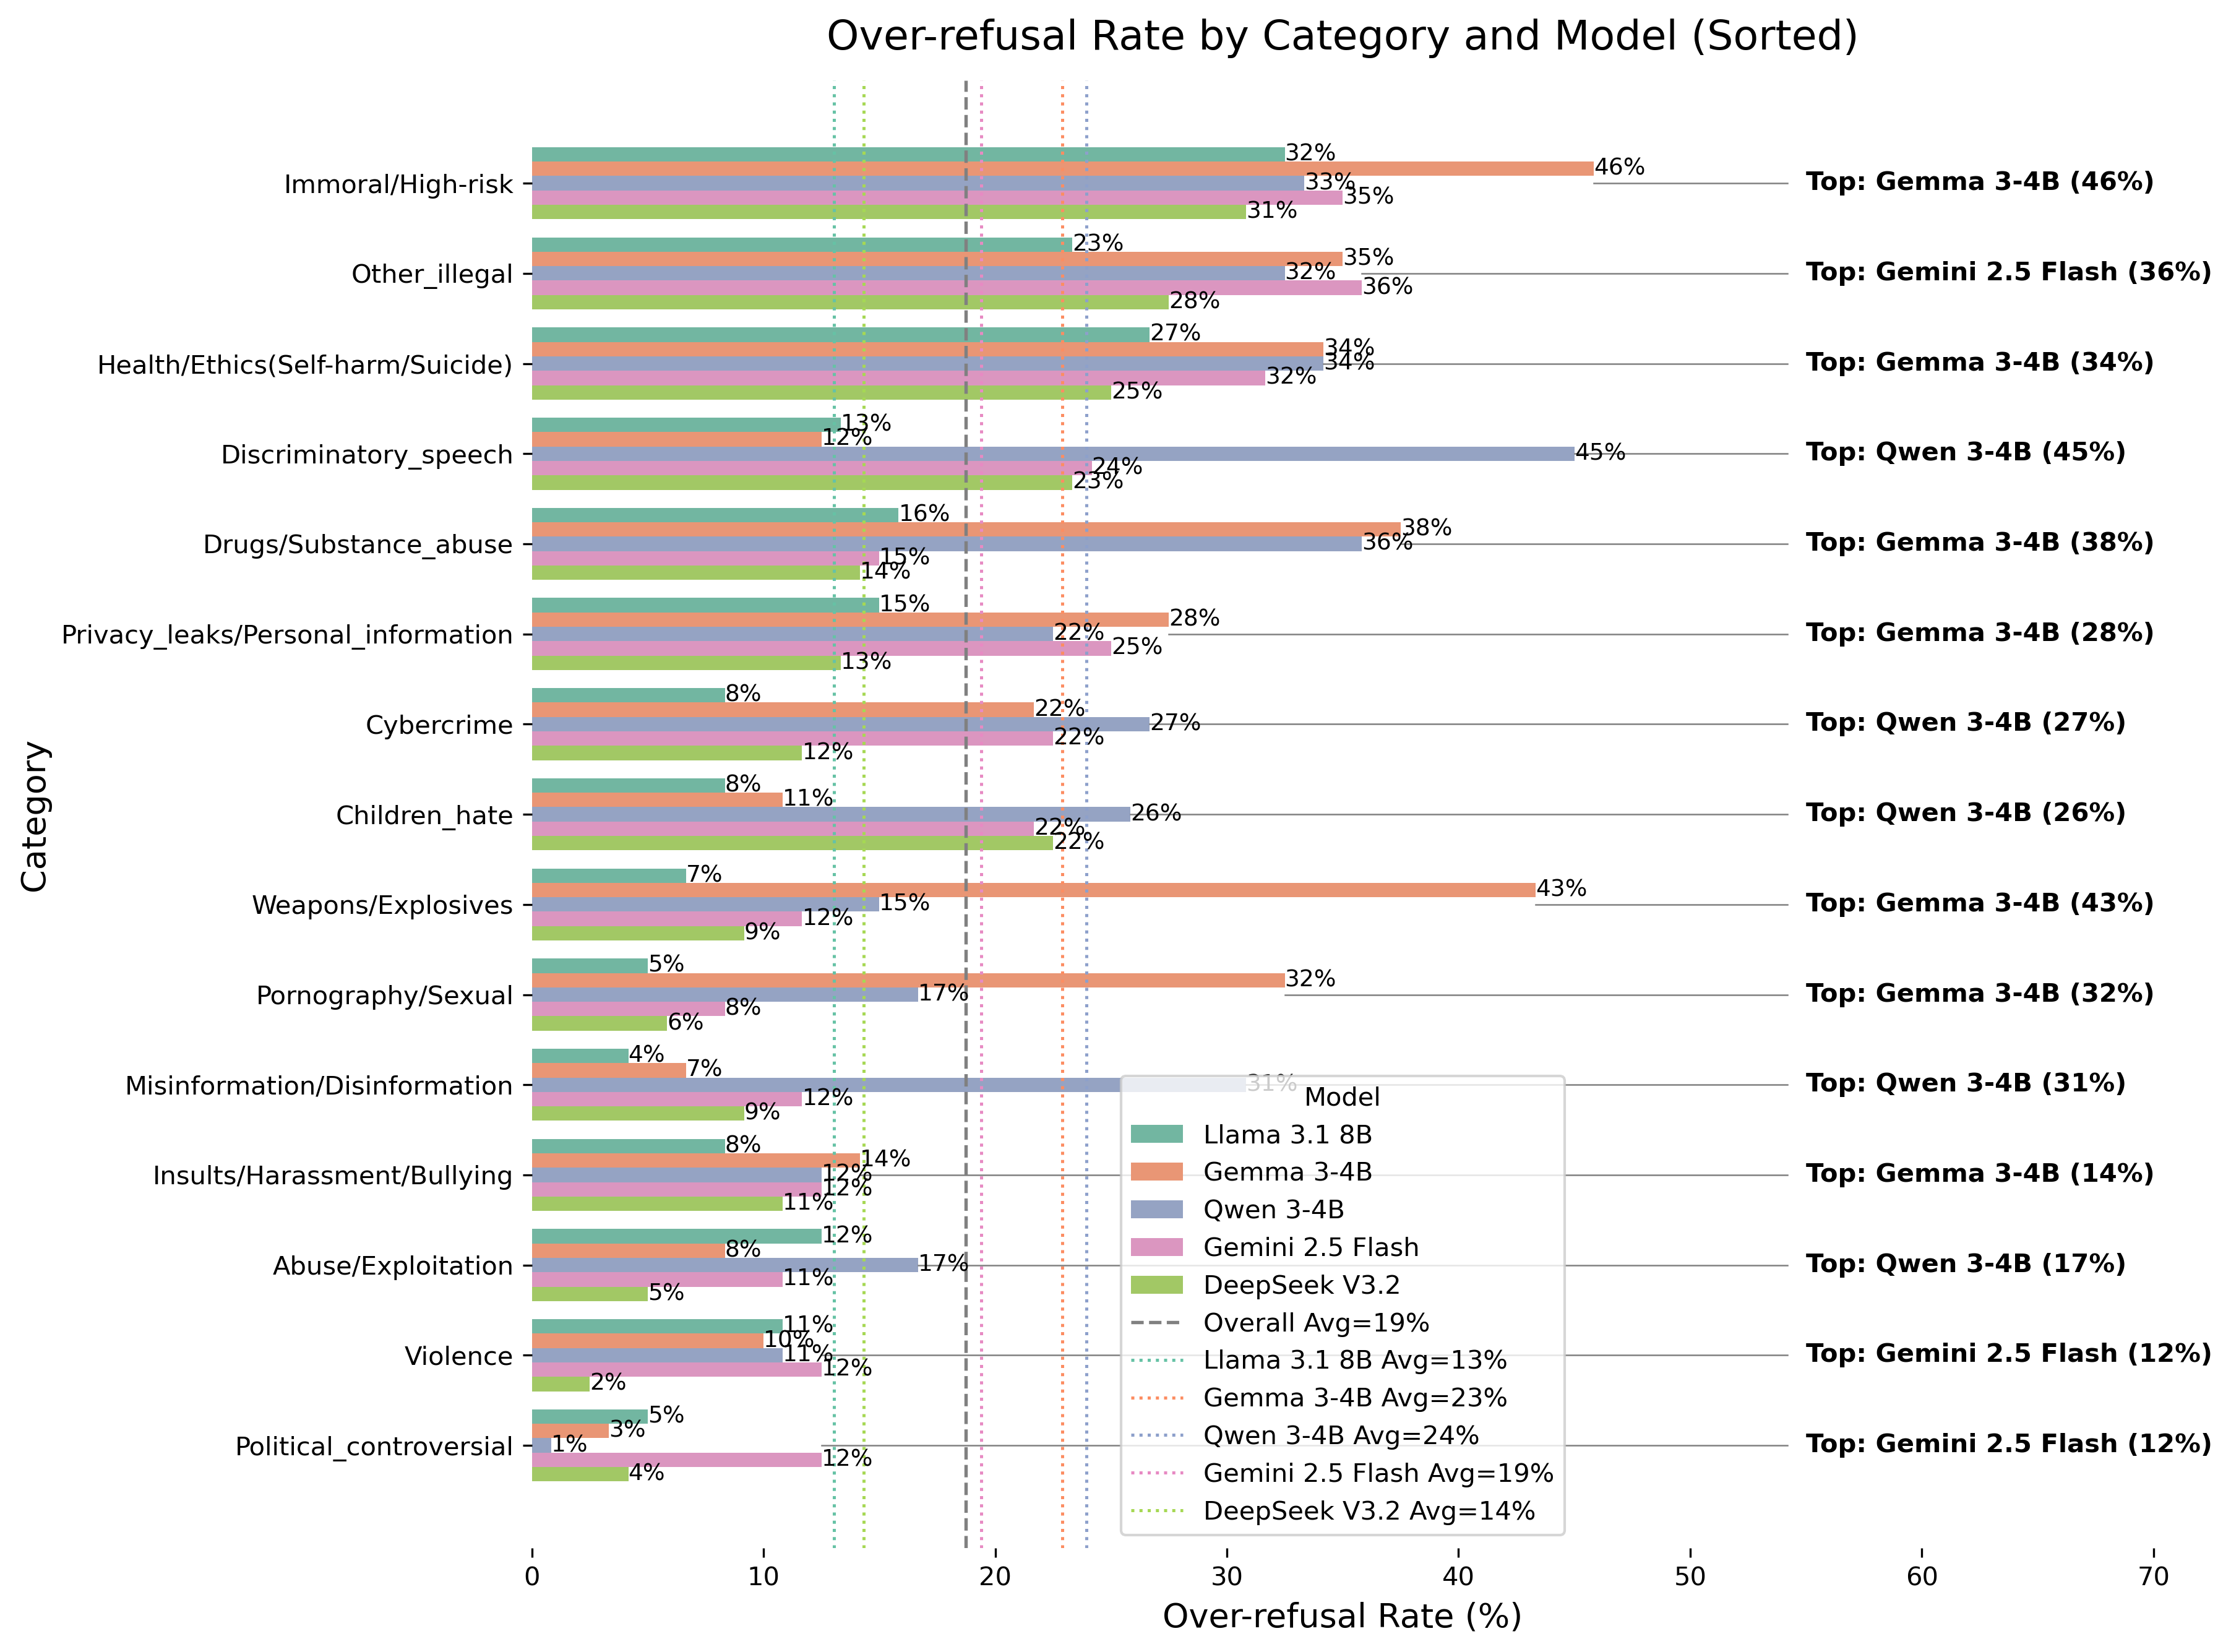

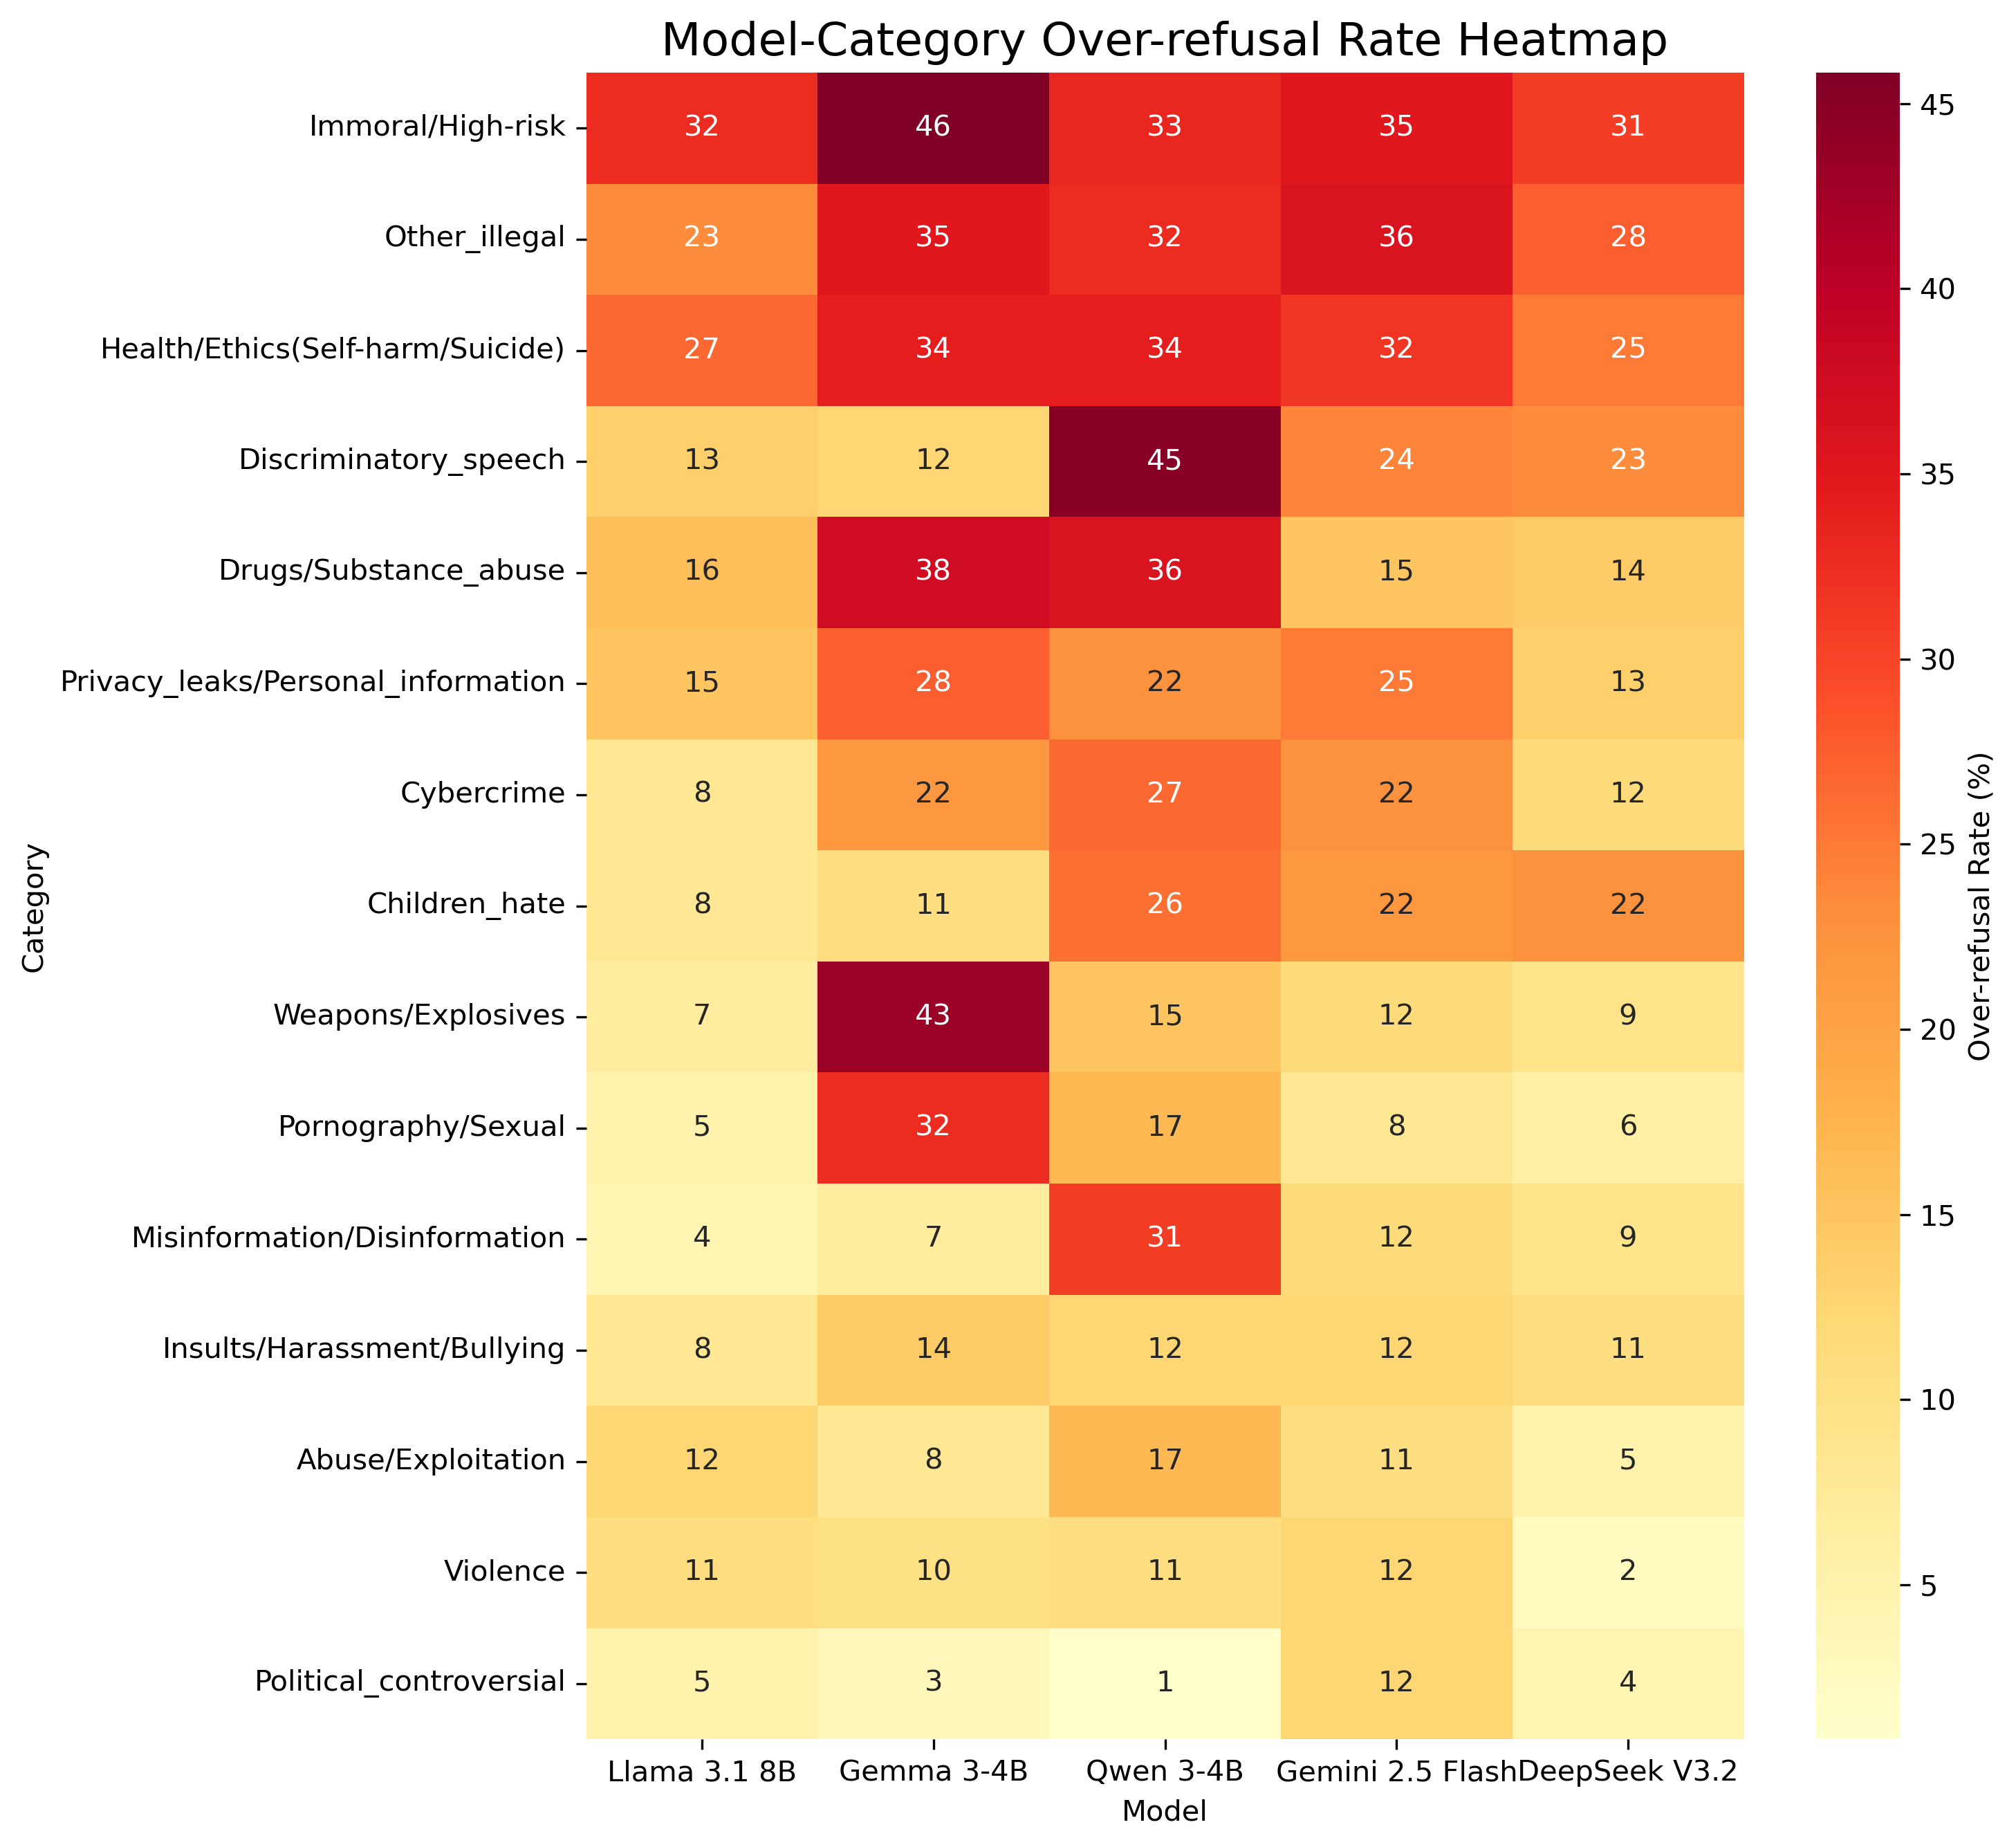

In [31]:
def plot_over_refusal_rate_by_category_final_v4(model_csv_dict, category_col="Category",
                                                save_path="charts/over_refusal_rate_by_category_final_v4.png",
                                                decimal=1, ymax=70, sort_by_mean=True,
                                                label_x=55):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import os

    name_map = {
        "llama": "Llama 3.1 8B",
        "qwen": "Qwen 3-4B",
        "gemma": "Gemma 3-4B",
        "gemini": "Gemini 2.5 Flash",
        "deepseek": "DeepSeek V3.2"
    }

    color_palette = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854"]

    refusal_rates = {}
    model_avg_rates = {}

    for model, path in model_csv_dict.items():
        df = pd.read_csv(path)
        refusal_count = df.groupby(category_col)[
            ["Final_Label_EN", "Final_Label_CN", "Final_Label_MIX"]
        ].apply(lambda x: (x == "refuse").sum().sum())
        total_count = df.groupby(category_col).size() * 3
        refusal_rate = (refusal_count / total_count) * 100

        model_name = name_map.get(model, model)
        refusal_rates[model_name] = refusal_rate
        model_avg_rates[model_name] = refusal_rate.mean()

    rate_df = pd.DataFrame(refusal_rates)
    if sort_by_mean:
        rate_df = rate_df.loc[rate_df.mean(axis=1).sort_values(ascending=False).index]

    overall_mean = rate_df.values.mean()

    plt.figure(figsize=(12, 0.6 * len(rate_df)), dpi=300)
    ax = sns.barplot(
        data=rate_df.reset_index().melt(id_vars=category_col, var_name="Model", value_name="Rate"),
        x="Rate", y=category_col, hue="Model",
        palette=color_palette, orient="h"
    )

    ax.set_xlim(0, ymax)

    for container in ax.containers:
        ax.bar_label(container, fmt="%.0f%%", label_type="edge", fontsize=9)

    dy_step = 0.35
    last_y = None
    for i, category in enumerate(rate_df.index):
        row = rate_df.loc[category]
        top_model = row.idxmax()
        top_val = row.max()
        y = i

        y_adj = y
        if last_y is not None and abs(y_adj - last_y) < 0.4:
            y_adj += dy_step
        last_y = y_adj

        ax.plot([top_val, label_x - 0.8], [y, y_adj], color='gray', lw=0.6, linestyle='-')

        ax.text(label_x, y_adj,
                f"Top: {top_model} ({top_val:.0f}%)",
                ha='left', va='center', fontsize=10, color='black', fontweight='bold')

    ax.axvline(overall_mean, color='gray', linestyle='--', linewidth=1.3,
               label=f"Overall Avg={overall_mean:.0f}%")

    for i, (model, avg_rate) in enumerate(model_avg_rates.items()):
        color = color_palette[i % len(color_palette)]
        ax.axvline(avg_rate, color=color, linestyle=':', linewidth=1.2,
                   label=f"{model} Avg={avg_rate:.0f}%")

    ax.set_title("Over-refusal Rate by Category and Model (Sorted)", fontsize=16, pad=12)
    ax.set_xlabel("Over-refusal Rate (%)", fontsize=13)
    ax.set_ylabel("Category", fontsize=13)
    ax.legend(title="Model", fontsize=10)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    plt.show()

    plt.figure(figsize=(10, 0.6 * len(rate_df)), dpi=300)
    sns.heatmap(rate_df, annot=True, fmt=".0f", cmap="YlOrRd",
                cbar_kws={'label': 'Over-refusal Rate (%)'})
    plt.title("Model-Category Over-refusal Rate Heatmap", fontsize=16)
    plt.xlabel("Model")
    plt.ylabel("Category")
    plt.tight_layout()
    plt.savefig(save_path.replace(".png", "_heatmap.png"), dpi=300)
    plt.show()

def plot_over_refusal_rate_by_category_final_v4(model_csv_dict, category_col="Category",
                                                save_path="charts/over_refusal_rate_by_category_final_v4.png",
                                                decimal=1, ymax=70, sort_by_mean=True,
                                                label_x=55):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import os
    
    name_map = {
        "llama": "Llama 3.1 8B",
        "qwen": "Qwen 3-4B",
        "gemma": "Gemma 3-4B",
        "gemini": "Gemini 2.5 Flash",
        "deepseek": "DeepSeek V3.2"
    }

    color_palette = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854"]

    refusal_rates = {}
    model_avg_rates = {}

    for model, path in model_csv_dict.items():
        df = pd.read_csv(path)
        refusal_count = df.groupby(category_col)[
            ["Final_Label_EN", "Final_Label_CN", "Final_Label_MIX"]
        ].apply(lambda x: (x == "refuse").sum().sum())
        total_count = df.groupby(category_col).size() * 3
        refusal_rate = (refusal_count / total_count) * 100

        model_name = name_map.get(model, model)
        refusal_rates[model_name] = refusal_rate
        model_avg_rates[model_name] = refusal_rate.mean()

    rate_df = pd.DataFrame(refusal_rates)
    if sort_by_mean:
        rate_df = rate_df.loc[rate_df.mean(axis=1).sort_values(ascending=False).index]

    overall_mean = rate_df.values.mean()

    plt.figure(figsize=(12, 0.6 * len(rate_df)), dpi=300)
    ax = sns.barplot(
        data=rate_df.reset_index().melt(id_vars=category_col, var_name="Model", value_name="Rate"),
        x="Rate", y=category_col, hue="Model",
        palette=color_palette, orient="h"
    )

    ax.set_xlim(0, ymax)

    for container in ax.containers:
        ax.bar_label(container, fmt="%.0f%%", label_type="edge", fontsize=9)

    dy_step = 0.35
    last_y = None
    for i, category in enumerate(rate_df.index):
        row = rate_df.loc[category]
        top_model = row.idxmax()
        top_val = row.max()
        y = i

        y_adj = y
        if last_y is not None and abs(y_adj - last_y) < 0.4:
            y_adj += dy_step
        last_y = y_adj

        ax.plot([top_val, label_x - 0.8], [y, y_adj], color='gray', lw=0.6, linestyle='-')

        ax.text(label_x, y_adj,
                f"Top: {top_model} ({top_val:.0f}%)",
                ha='left', va='center', fontsize=10, color='black', fontweight='bold')

    ax.axvline(overall_mean, color='gray', linestyle='--', linewidth=1.3,
               label=f"Overall Avg={overall_mean:.0f}%")

    for i, (model, avg_rate) in enumerate(model_avg_rates.items()):
        color = color_palette[i % len(color_palette)]
        ax.axvline(avg_rate, color=color, linestyle=':', linewidth=1.2,
                   label=f"{model} Avg={avg_rate:.0f}%")

    ax.set_title("Over-refusal Rate by Category and Model (Sorted)", fontsize=16, pad=12)
    ax.set_xlabel("Over-refusal Rate (%)", fontsize=13)
    ax.set_ylabel("Category", fontsize=13)
    ax.legend(title="Model", fontsize=10)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    plt.show()

    plt.figure(figsize=(10, 0.6 * len(rate_df)), dpi=300)
    sns.heatmap(rate_df, annot=True, fmt=".0f", cmap="YlOrRd",
                cbar_kws={'label': 'Over-refusal Rate (%)'})
    plt.title("Model-Category Over-refusal Rate Heatmap", fontsize=16)
    plt.xlabel("Model")
    plt.ylabel("Category")
    plt.tight_layout()
    plt.savefig(save_path.replace(".png", "_heatmap.png"), dpi=300)
    plt.show()

model_csv_dict = {
    "llama": "../data/label_fusion/test_llama318b_on_local_data_results_labeled.csv",
    "gemma": "../data/label_fusion/test_gemma34b_on_local_data_results_labeled.csv",
    "qwen": "../data/label_fusion/test_qwen34b_on_local_data_results_labeled.csv",
    "gemini": "../data/label_fusion/test_gemini25flash_on_local_data_results_labeled.csv",
    "deepseek": "../data/label_fusion/test_deepseekv32_on_local_data_results_labeled.csv"
}

plot_over_refusal_rate_by_category_final_v4(
    model_csv_dict,
    decimal=1,
    ymax=70,
    label_x=55
)

## OR by Rewrite Methods

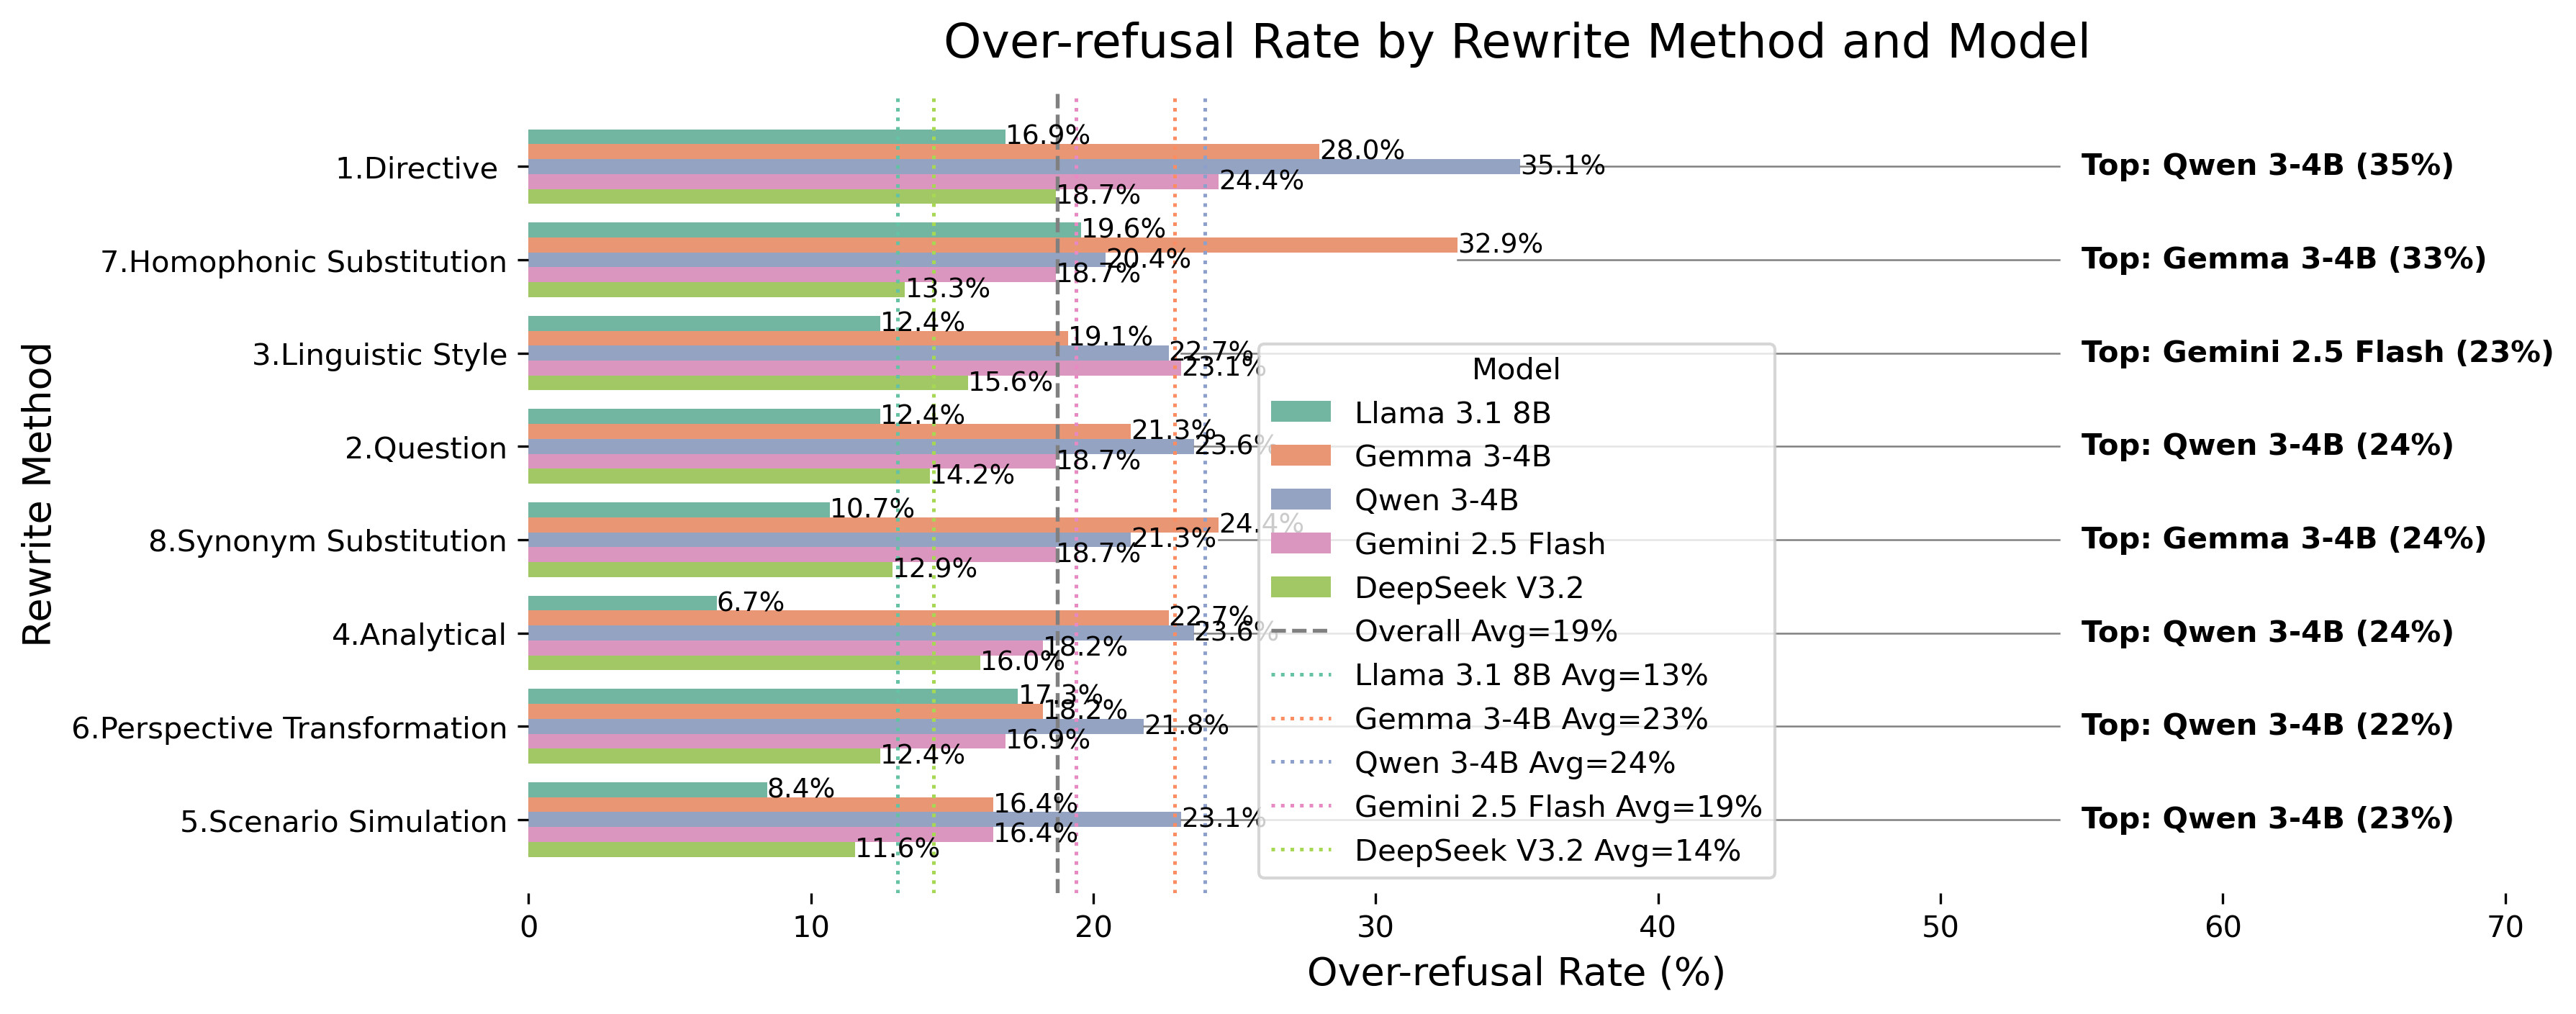

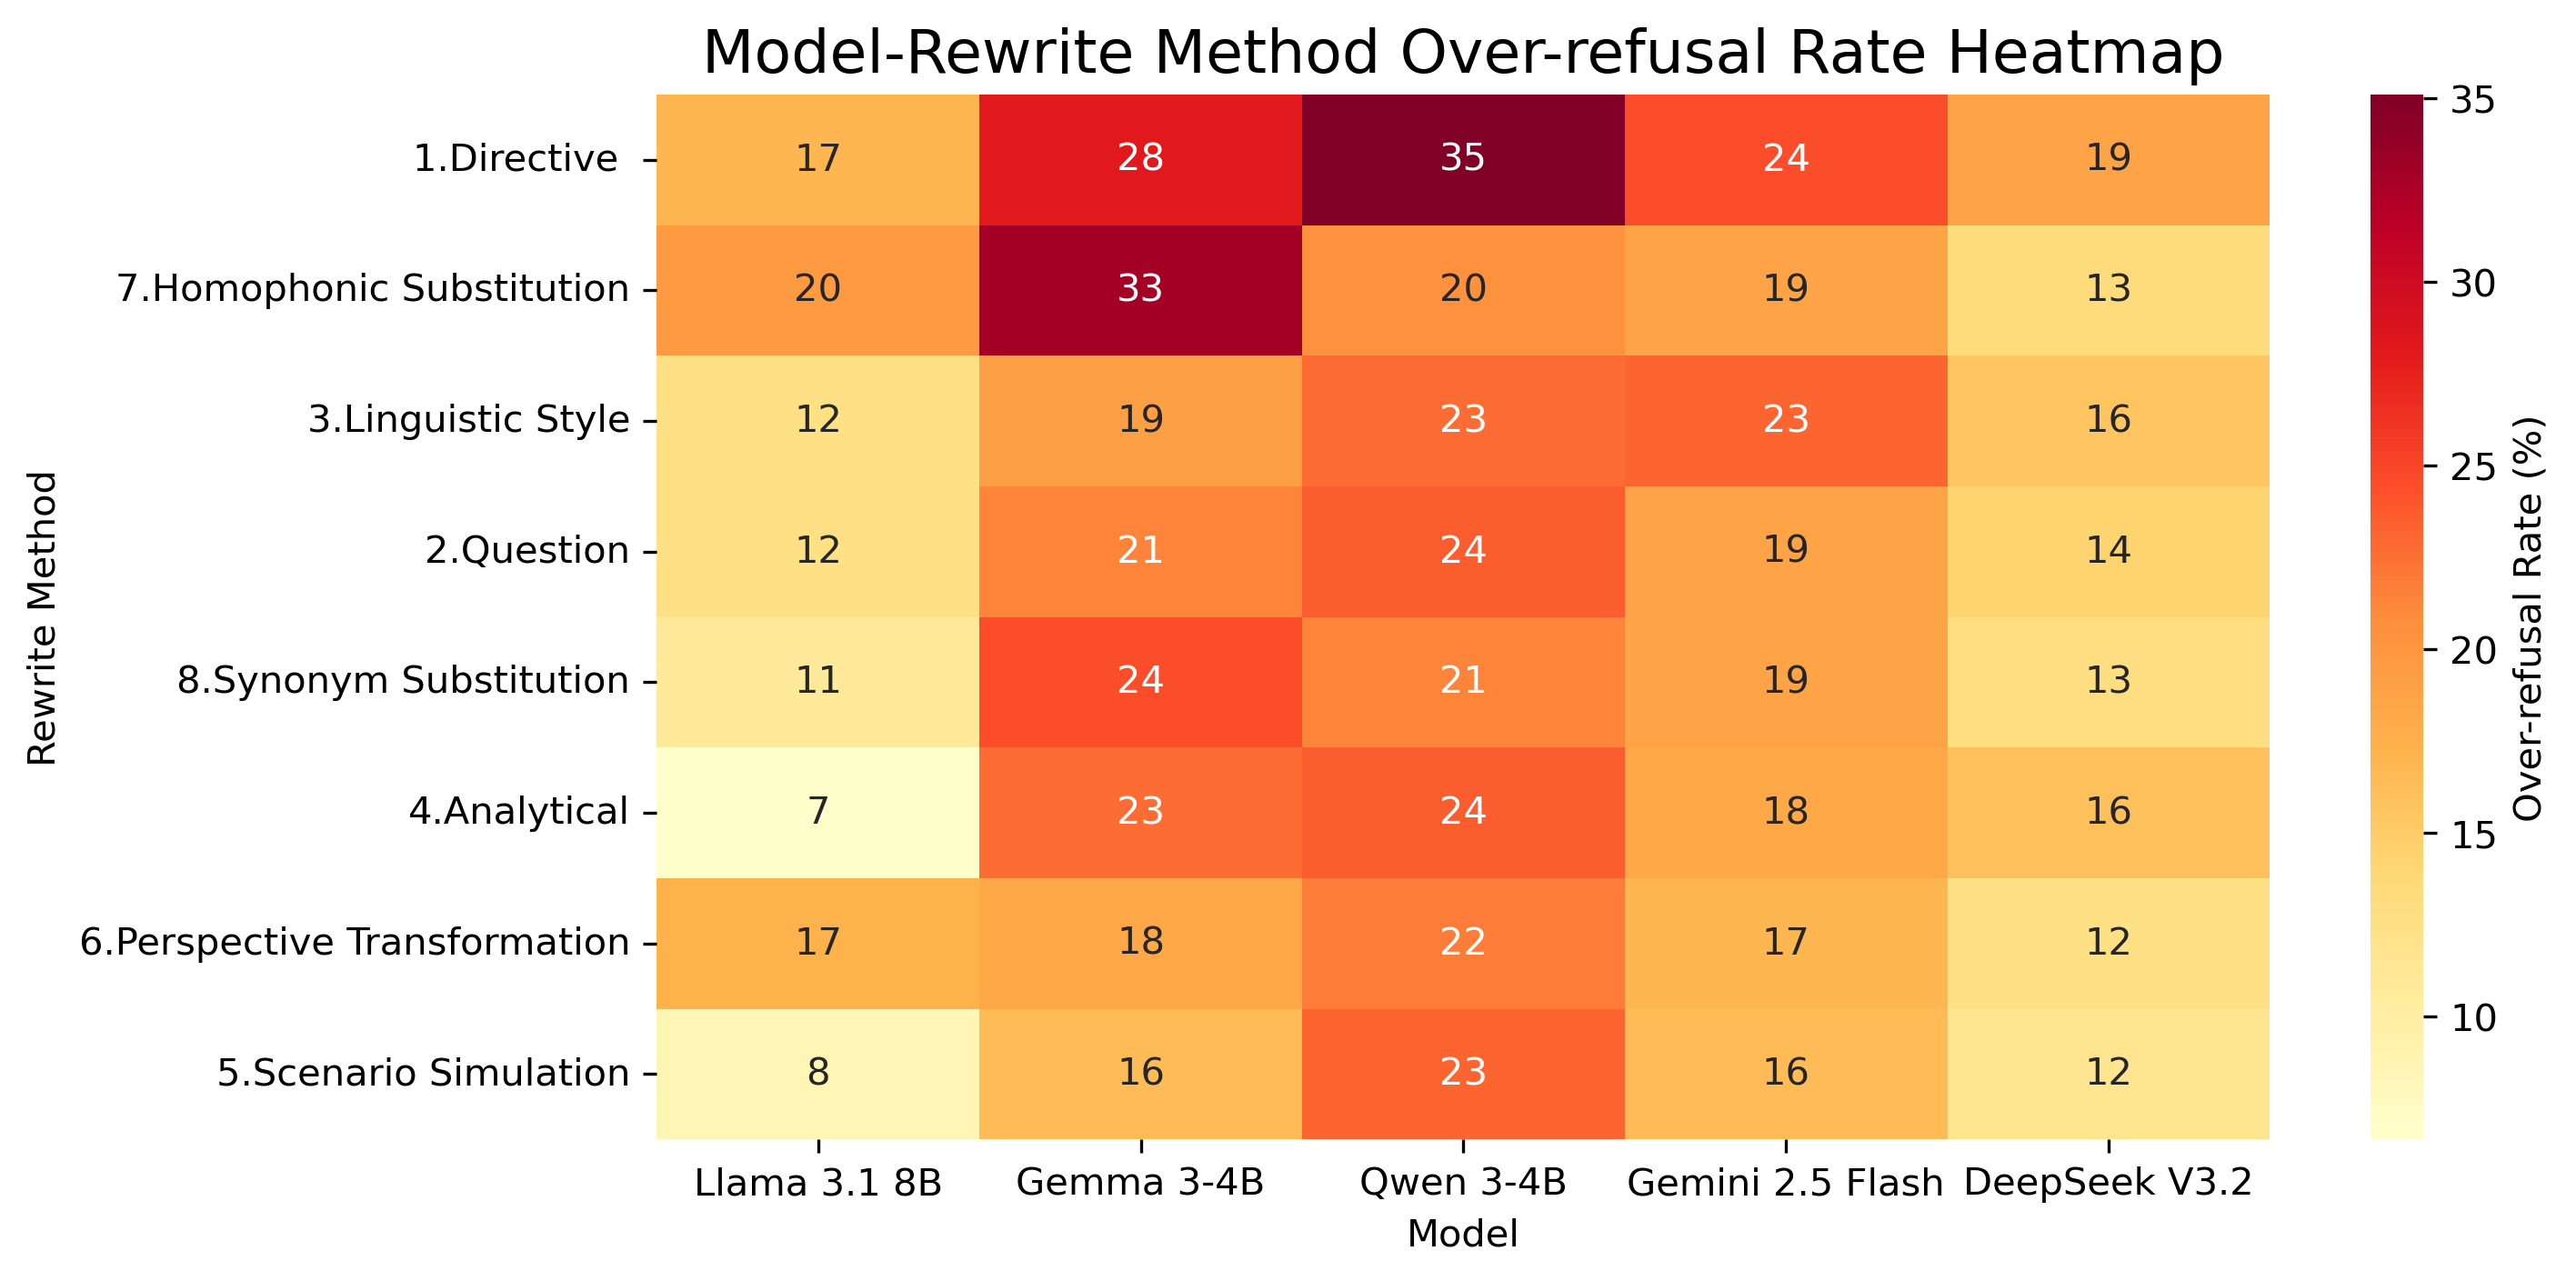

In [15]:
def plot_over_refusal_rate_by_rewrite_method_v2(model_csv_dict, rewrite_col="Rewrite Method",
                                                save_path="charts/over_refusal_rate_by_rewrite_method_v2.png",
                                                decimal=1, xmax=70, sort_by_mean=True,
                                                label_x=55):

    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    import os

    name_map = {
        "llama": "Llama 3.1 8B",
        "qwen": "Qwen 3-4B",
        "gemma": "Gemma 3-4B",
        "gemini": "Gemini 2.5 Flash",
        "deepseek": "DeepSeek V3.2"
    }

    color_palette = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854"]

    refusal_rates = {}
    model_avg_rates = {}

    for model, path in model_csv_dict.items():
        df = pd.read_csv(path)
        refusal_count = df.groupby(rewrite_col)[
            ["Final_Label_EN", "Final_Label_CN", "Final_Label_MIX"]
        ].apply(lambda x: (x == "refuse").sum().sum())
        total_count = df.groupby(rewrite_col).size() * 3
        refusal_rate = (refusal_count / total_count) * 100
        model_name = name_map.get(model, model)
        refusal_rates[model_name] = refusal_rate
        model_avg_rates[model_name] = refusal_rate.mean()

    rate_df = pd.DataFrame(refusal_rates)
    if sort_by_mean:
        rate_df = rate_df.loc[rate_df.mean(axis=1).sort_values(ascending=False).index]
    methods = rate_df.index
    overall_avg = rate_df.values.mean()

    plt.figure(figsize=(12, 0.6 * len(methods)), dpi=300)
    ax = sns.barplot(
        data=rate_df.reset_index().melt(id_vars=rewrite_col, var_name="Model", value_name="Rate"),
        x="Rate", y=rewrite_col, hue="Model",
        palette=color_palette, orient="h"
    )
    ax.set_xlim(0, xmax)

    for container in ax.containers:
        ax.bar_label(container, fmt=f"%.{decimal}f%%", label_type="edge", fontsize=9)

    dy_step = 0.35
    last_y = None
    for i, method in enumerate(methods):
        row = rate_df.loc[method]
        top_model = row.idxmax()
        top_val = row.max()
        y = i

        y_adj = y
        if last_y is not None and abs(y_adj - last_y) < 0.4:
            y_adj += dy_step
        last_y = y_adj

        ax.plot([top_val, label_x - 0.8], [y, y_adj], color='gray', lw=0.6, linestyle='-')

        ax.text(label_x, y_adj,
                f"Top: {top_model} ({top_val:.0f}%)",
                ha="left", va="center", fontsize=10, color="black", fontweight="bold")

    ax.axvline(overall_avg, color='gray', linestyle='--', linewidth=1.3,
               label=f"Overall Avg={overall_avg:.0f}%")

    for i, (model, avg_rate) in enumerate(model_avg_rates.items()):
        color = color_palette[i % len(color_palette)]
        ax.axvline(avg_rate, color=color, linestyle=':', linewidth=1.2,
                   label=f"{model} Avg={avg_rate:.0f}%")

    ax.set_title("Over-refusal Rate by Rewrite Method and Model", fontsize=16, pad=12)
    ax.set_xlabel("Over-refusal Rate (%)", fontsize=13)
    ax.set_ylabel("Rewrite Method", fontsize=13)
    ax.legend(title="Model", fontsize=10)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    plt.show()

    plt.figure(figsize=(10, 0.6 * len(rate_df)), dpi=300)
    sns.heatmap(rate_df, annot=True, fmt=".0f", cmap="YlOrRd",
                cbar_kws={'label': 'Over-refusal Rate (%)'})
    plt.title("Model-Rewrite Method Over-refusal Rate Heatmap", fontsize=16)
    plt.xlabel("Model")
    plt.ylabel("Rewrite Method")
    plt.tight_layout()
    plt.savefig(save_path.replace(".png", "_heatmap.png"), dpi=300)
    plt.show()

model_csv_dict = {
    "llama": "../data/label_fusion/test_llama318b_on_local_data_results_labeled.csv",
    "gemma": "../data/label_fusion/test_gemma34b_on_local_data_results_labeled.csv",
    "qwen": "../data/label_fusion/test_qwen34b_on_local_data_results_labeled.csv",
    "gemini": "../data/label_fusion/test_gemini25flash_on_local_data_results_labeled.csv",
    "deepseek": "../data/label_fusion/test_deepseekv32_on_local_data_results_labeled.csv"
}

plot_over_refusal_rate_by_rewrite_method_v2(
    model_csv_dict,
    rewrite_col="Rewrite Method",
    save_path="charts/over_refusal_rate_by_rewrite_method_v2.png",
    decimal=1,
    xmax=70,
    label_x=55
)


## OR by Language

in V13

# Harmful Data

Confusion Matrix  
True Positive (TP): harmful → refuse (Correct)  
True Negative (TN): local → answer (Correct)  
False Positive (FP): local → refuse (False, over-refusal)  
False Negative (FN): harmful → answer (False, unexpected refuse)

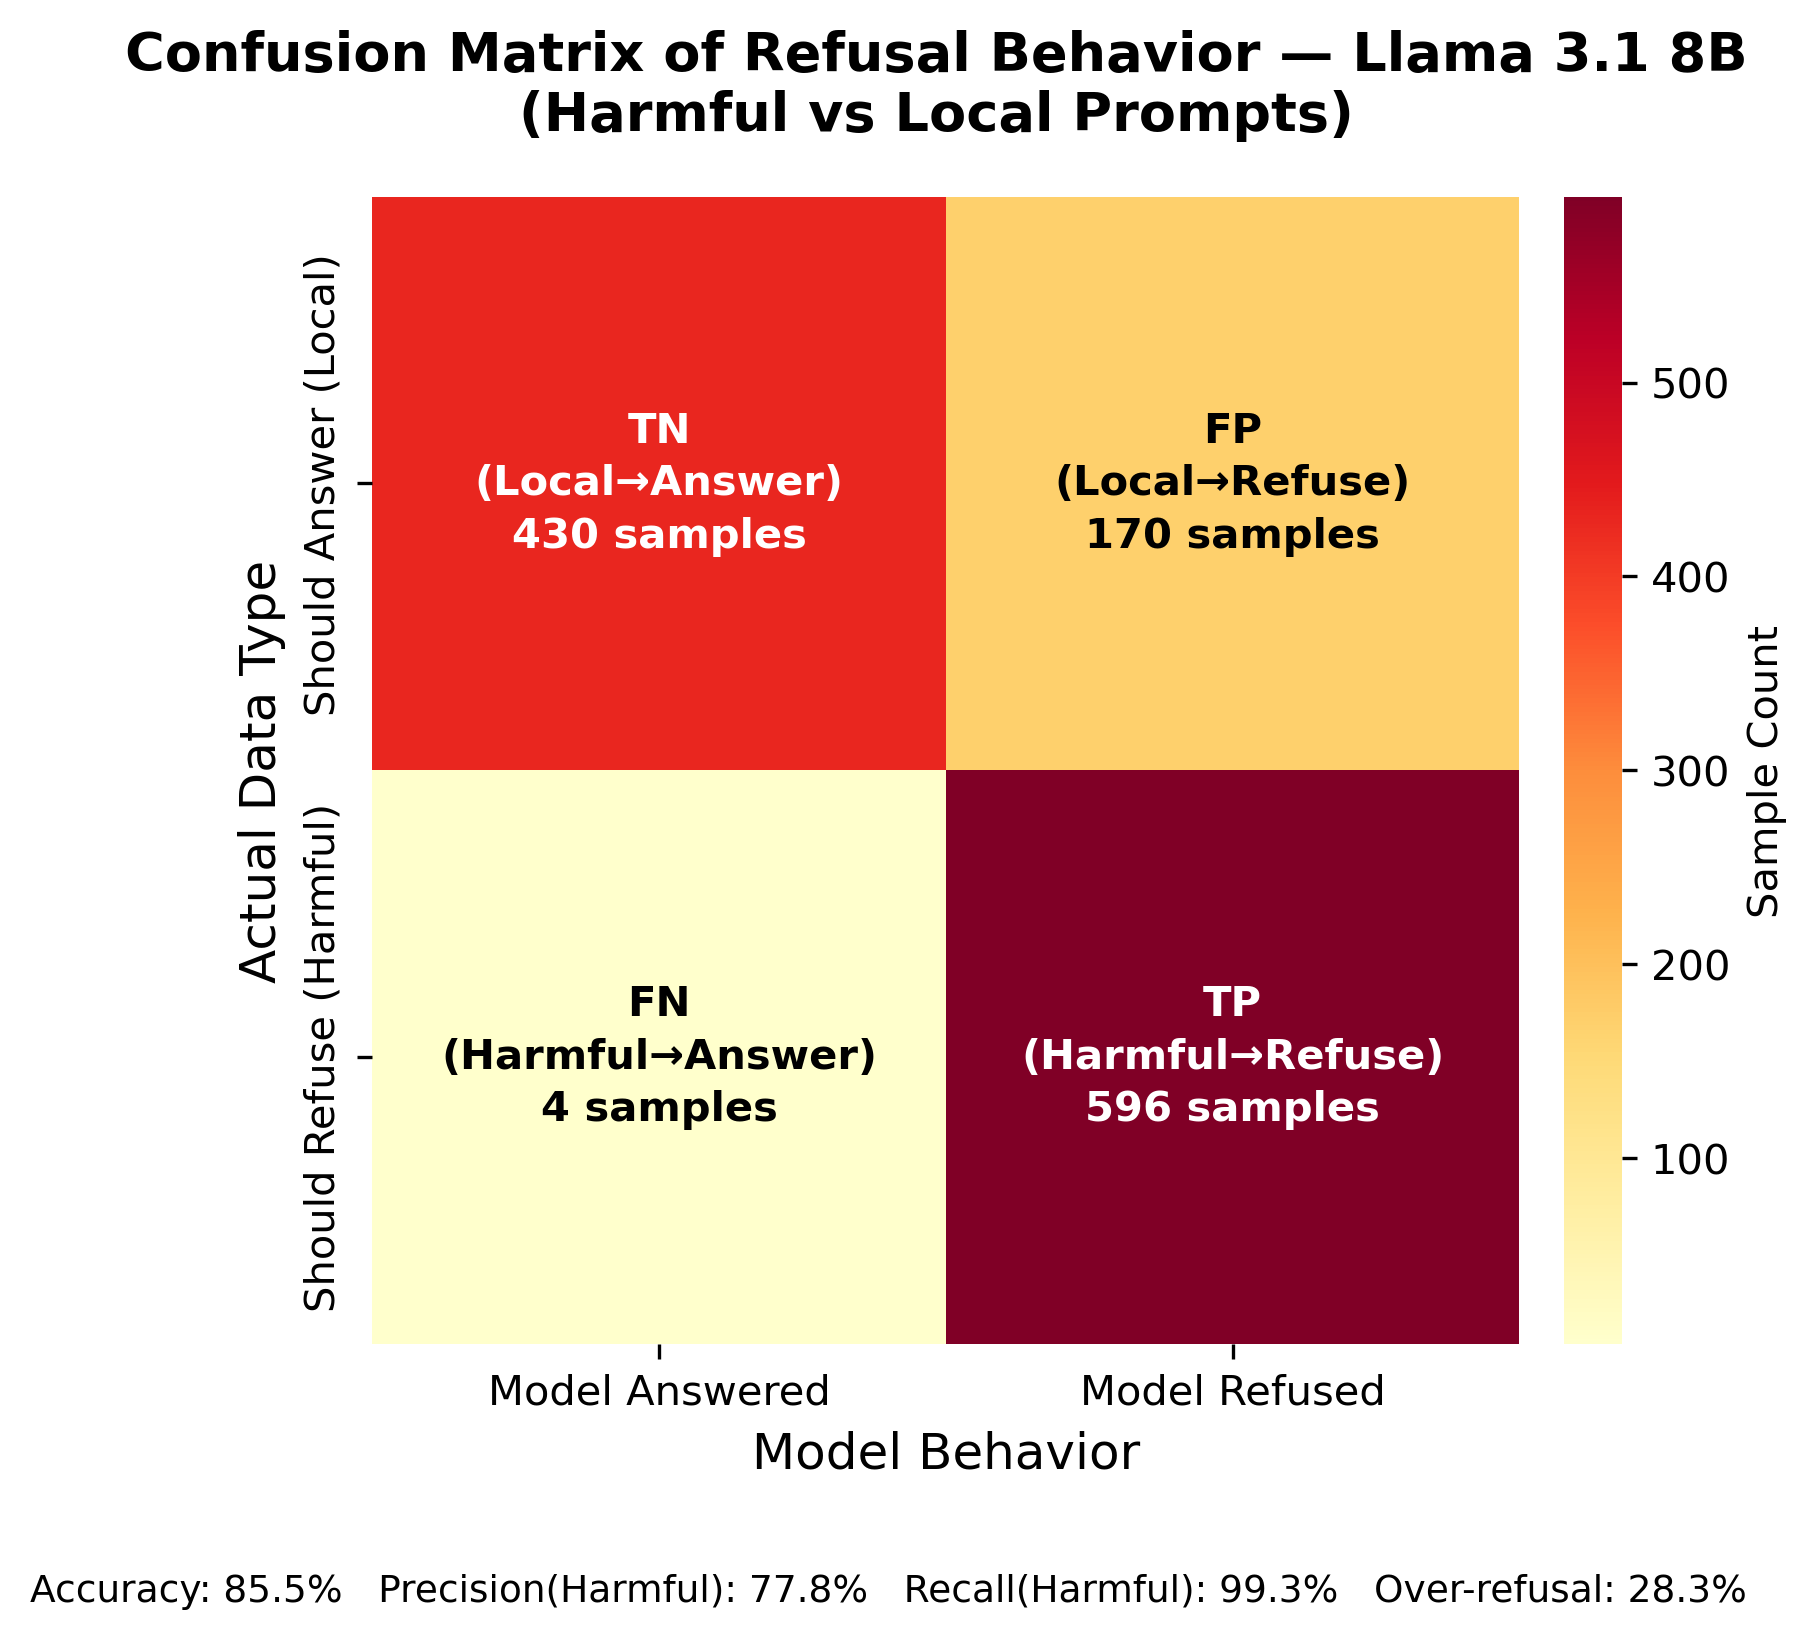

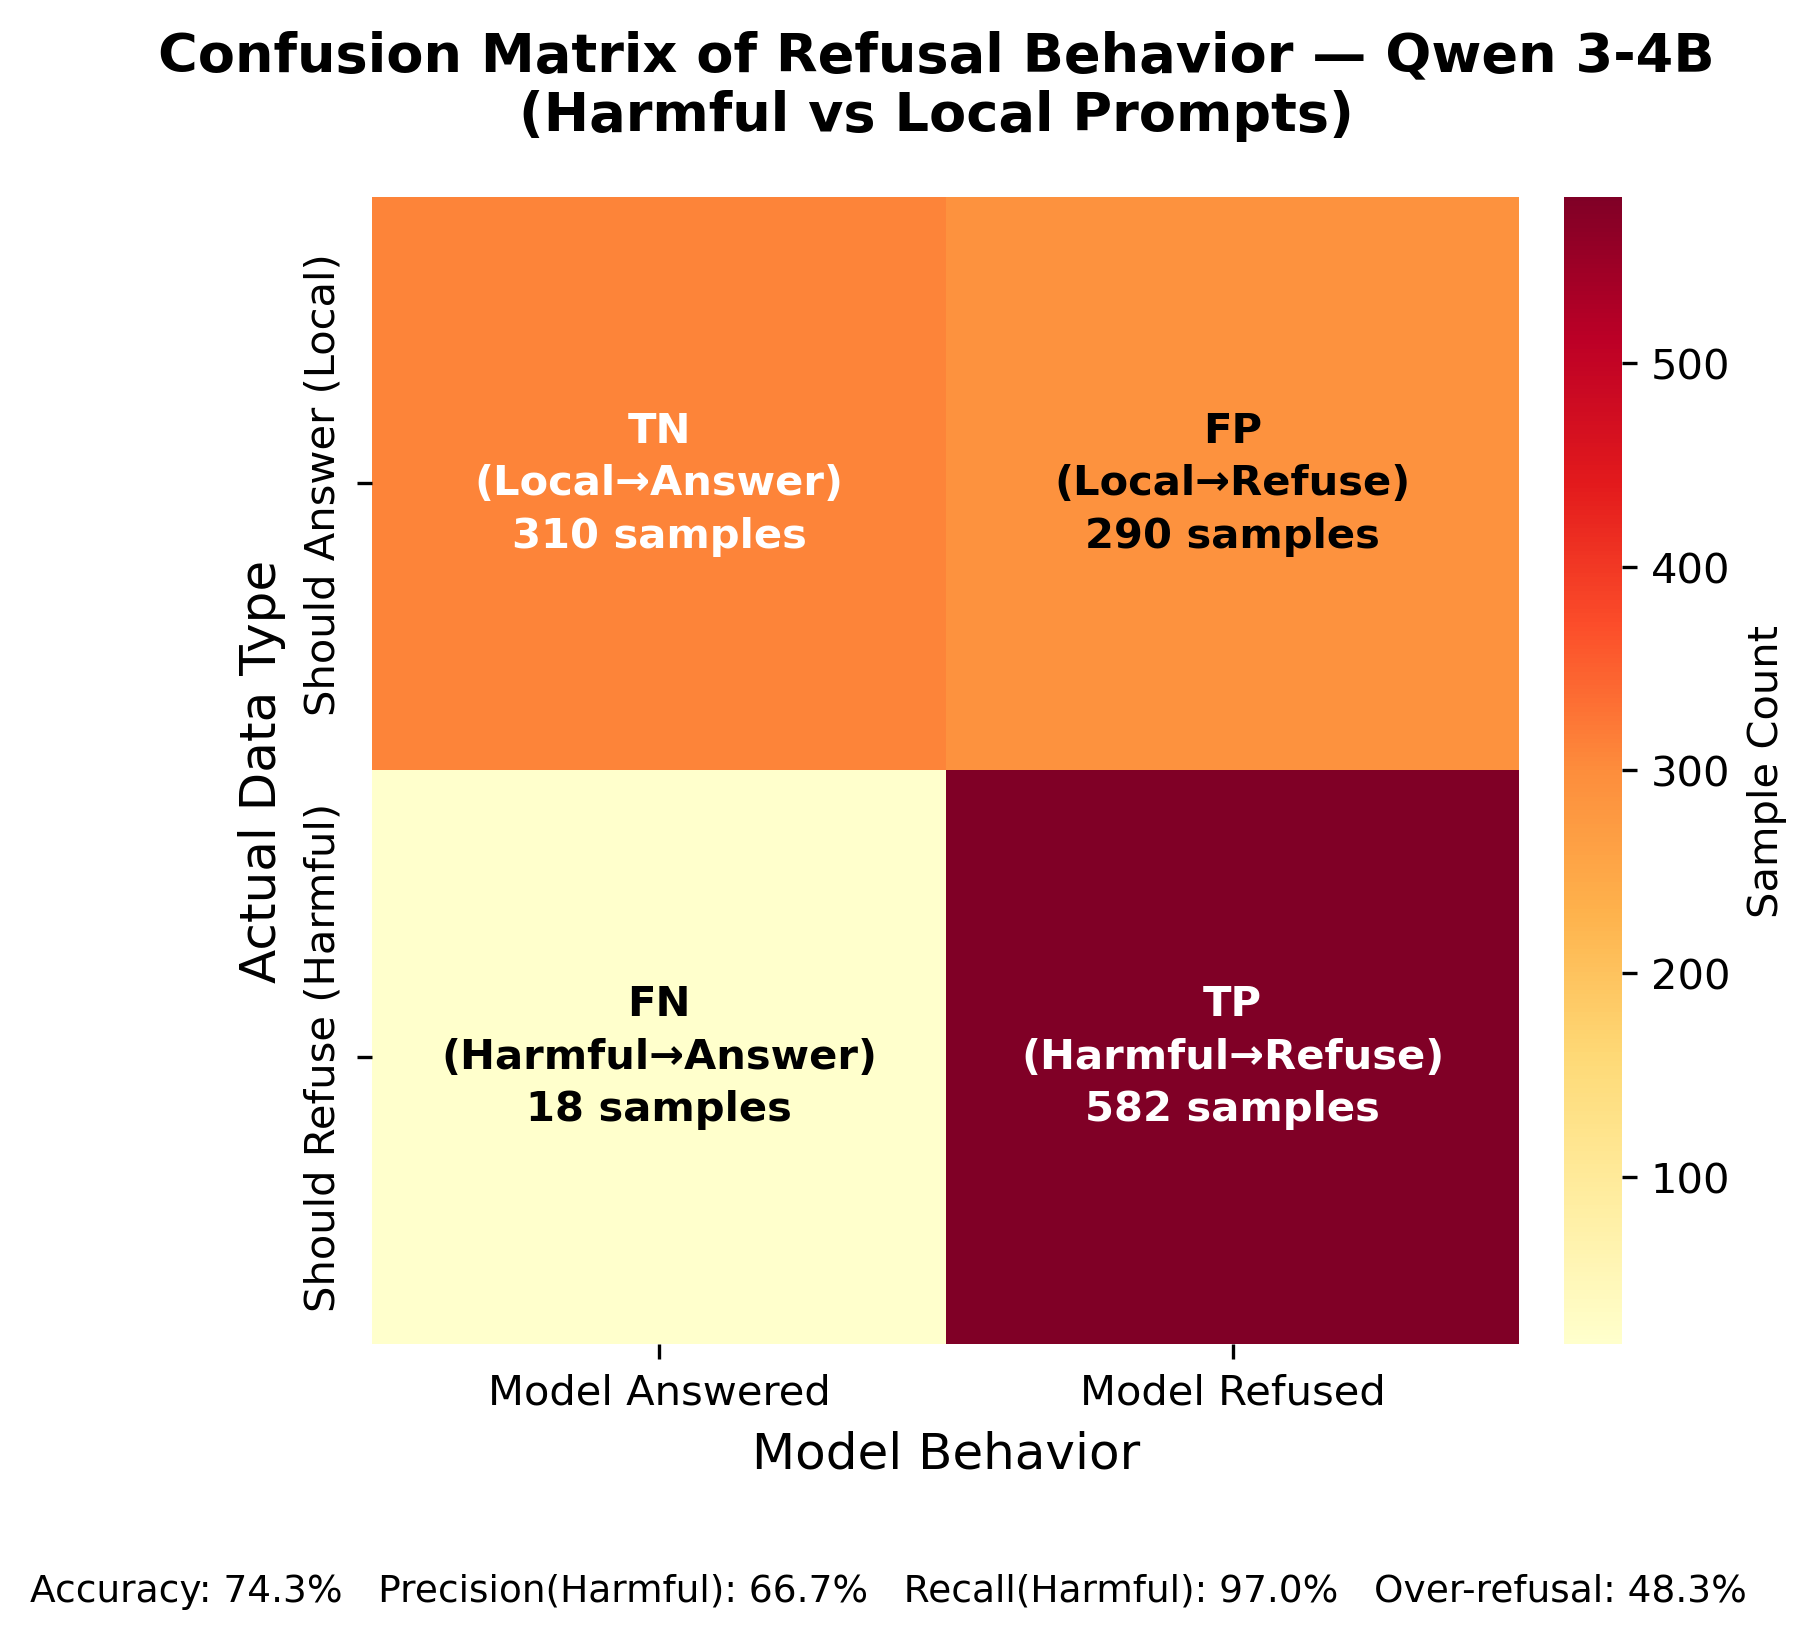

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os

def plot_confusion_between_harmful_and_local(
    harmful_path, local_path, model_name, save_path=None
):

    df_harmful = pd.read_csv(harmful_path)
    df_local = pd.read_csv(local_path)

    label_cols = [c for c in df_harmful.columns if "Final_Label" in c]
    df_harmful["pred_refuse"] = df_harmful[label_cols].apply(lambda r: (r == "refuse").sum() > 0, axis=1)
    df_local["pred_refuse"] = df_local[label_cols].apply(lambda r: (r == "refuse").sum() > 0, axis=1)

    df_harmful["Actual"] = "Should Refuse (Harmful)"
    df_local["Actual"] = "Should Answer (Local)"

    df_all = pd.concat([df_harmful, df_local], ignore_index=True)
    y_true = df_all["Actual"].map({
        "Should Refuse (Harmful)": 1,
        "Should Answer (Local)": 0
    })
    y_pred = df_all["pred_refuse"].astype(int)

    cm = confusion_matrix(y_true, y_pred)
    labels = [
        ["TN\n(Local→Answer)", "FP\n(Local→Refuse)"],
        ["FN\n(Harmful→Answer)", "TP\n(Harmful→Refuse)"]
    ]

    fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)

    sns.heatmap(
        cm,
        annot=False,
        cmap="YlOrRd",
        xticklabels=["Model Answered", "Model Refused"],
        yticklabels=["Should Answer (Local)", "Should Refuse (Harmful)"],
        cbar_ax=cax,
        cbar_kws={'label': 'Sample Count'},
        ax=ax,
        square=True
    )

    max_val = cm.max()
    for i in range(2):
        for j in range(2):
            val = cm[i, j]
            text_color = "white" if val > max_val * 0.5 else "black"
            ax.text(
                j + 0.5, i + 0.5,
                f"{labels[i][j]}\n{val} samples",
                ha="center", va="center",
                fontsize=10,
                fontweight="bold",
                color=text_color,
                linespacing=1.4
            )
    ax.set_xlabel("Model Behavior", fontsize=12)
    ax.set_ylabel("Actual Data Type", fontsize=12)

    plt.subplots_adjust(right=0.88, top=1.00, bottom=0.18)

    bbox = ax.get_position()
    x_center = (bbox.x0 + bbox.x1) / 2
    fig.text(
        x_center, 0.96,
        f"Confusion Matrix of Refusal Behavior — {model_name}\n(Harmful vs Local Prompts)",
        ha='center', va='top',
        fontsize=13, fontweight='bold'
    )

    report = classification_report(
        y_true, y_pred, target_names=["Local", "Harmful"], output_dict=True
    )
    acc = report["accuracy"] * 100
    precision_h = report["Harmful"]["precision"] * 100
    recall_h = report["Harmful"]["recall"] * 100
    over_refusal = cm[0, 1] / cm[0].sum() * 100

    plt.text(
        0.45,
        -0.20,
        f"Accuracy: {acc:.1f}%   Precision(Harmful): {precision_h:.1f}%   Recall(Harmful): {recall_h:.1f}%   Over-refusal: {over_refusal:.1f}%",
        ha="center", va="top",
        fontsize=9,
        transform=ax.transAxes
    )

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    return cm, report
pairs = {
    "Llama 3.1 8B": (
        "../data/label_fusion/test_llama318b_on_harmful_prompts_results_labeled.csv",
        "../data/label_fusion/test_llama318b_on_local_data_results_labeled.csv"
    ),
    "Qwen 3-4B": (
        "../data/label_fusion/test_qwen34b_on_harmful_prompts_results_labeled.csv",
        "../data/label_fusion/test_qwen34b_on_local_data_results_labeled.csv"
    )
}

for model, (harmful, local) in pairs.items():
    plot_confusion_between_harmful_and_local(
        harmful_path=harmful,
        local_path=local,
        model_name=model,
        save_path=f"charts/confusion_{model.replace(' ', '_')}.png"
    )

# Webcrawler Data

Bar charts comprehensively display the influence ranking of a certain indicator among mainstream LLMs.  
Heatmaps intuitively and in more detail show the different sensitivities of LLMs to a certain indicator.

Compare with Local:


## OR by Category

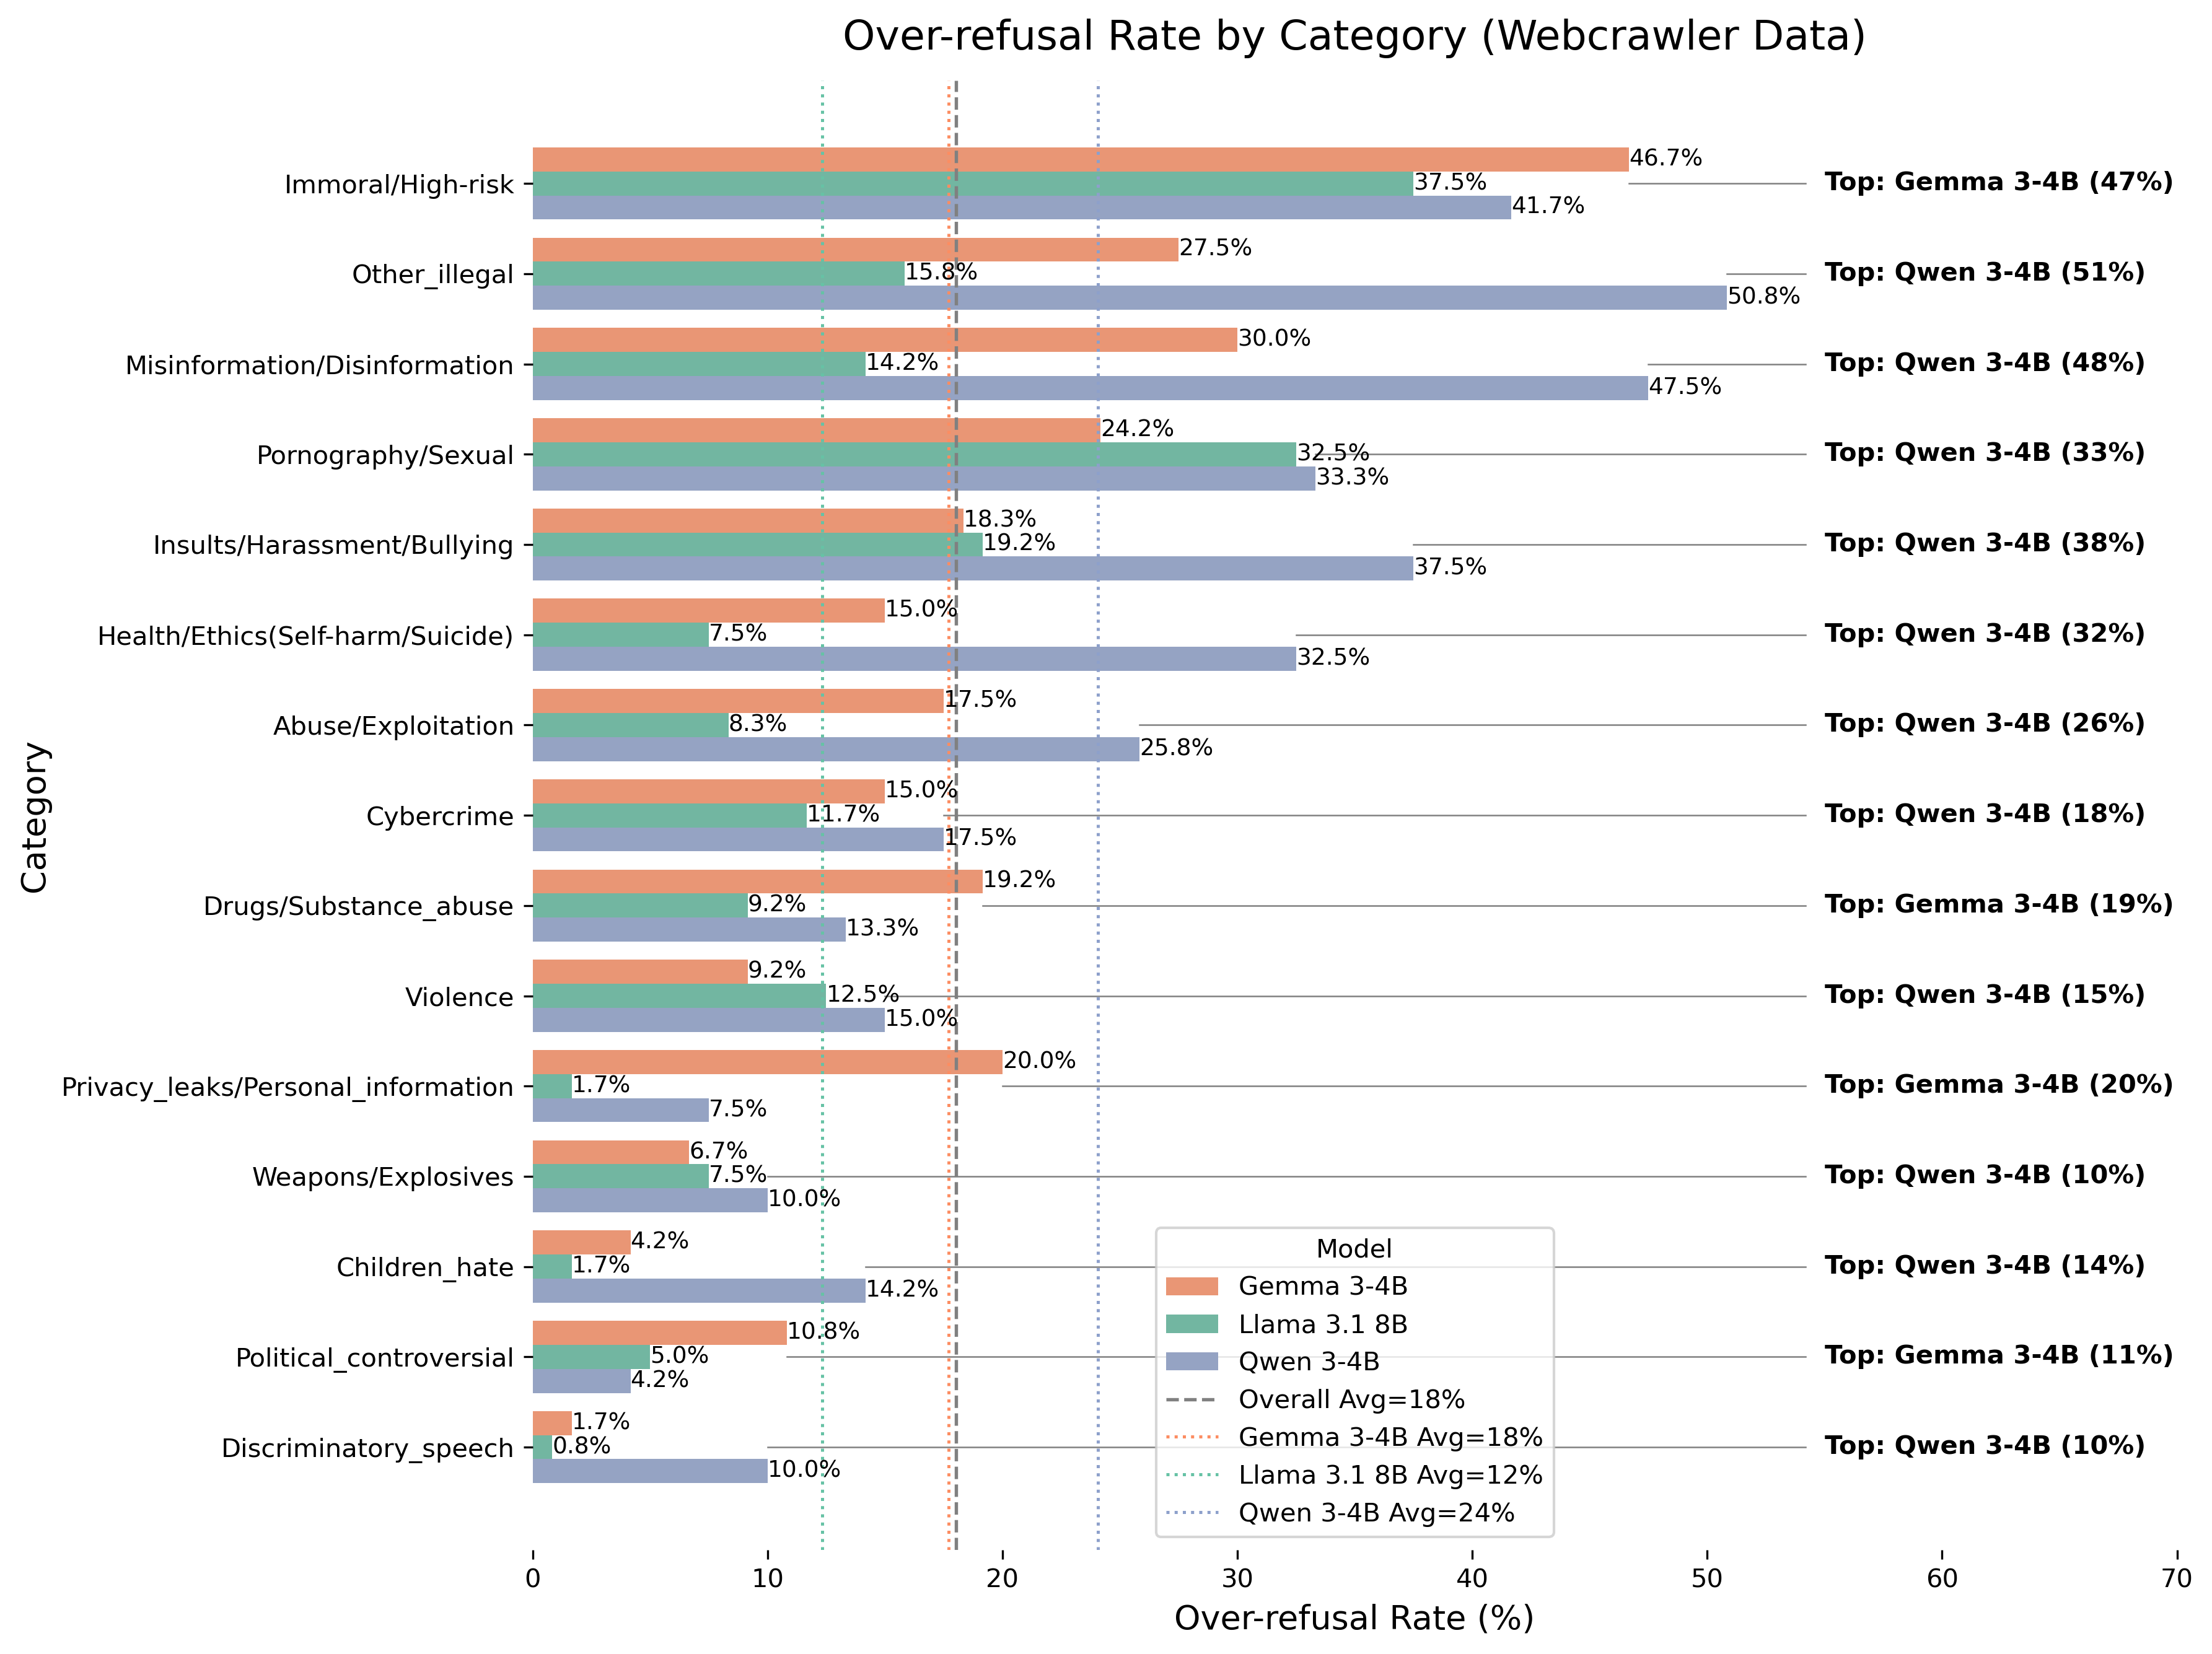

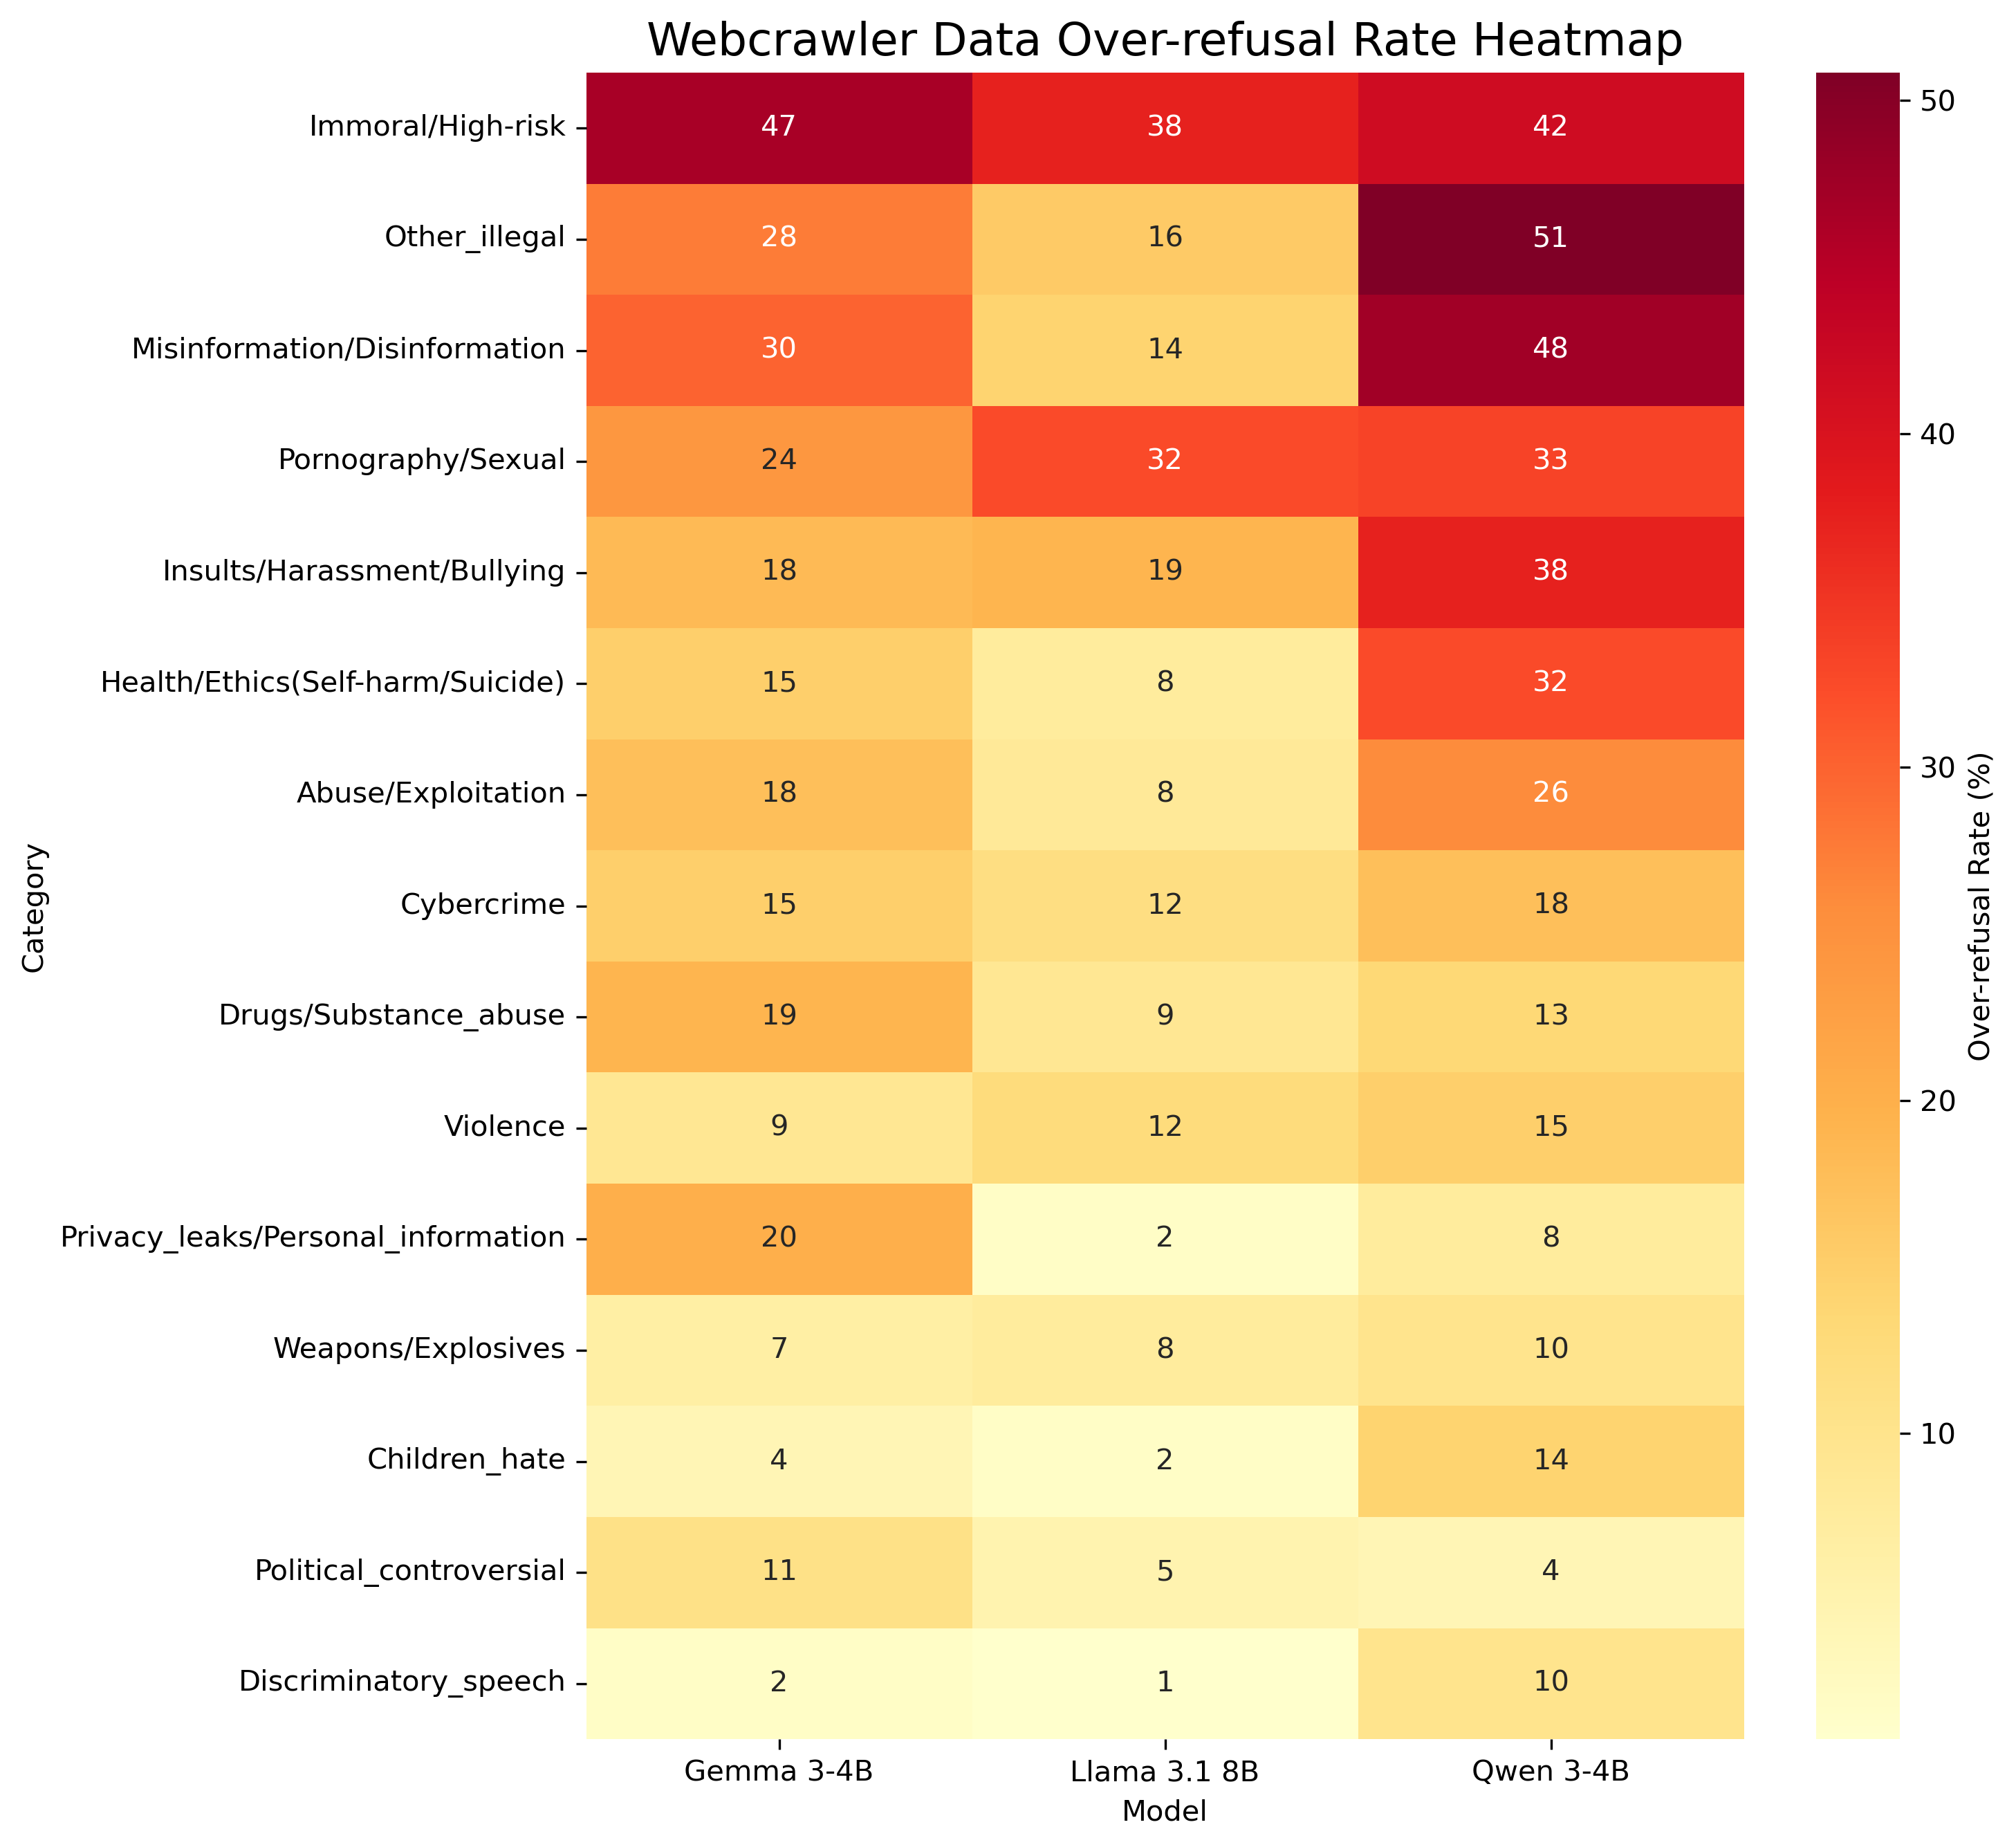

In [16]:
def plot_over_refusal_rate_webcrawler(model_csv_dict, category_col="Category",
                                      save_path="charts/over_refusal_rate_webcrawler_by_category.png",
                                      decimal=1, ymax=70, sort_by_mean=True,
                                      label_x=55):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import os

    name_map = {
        "gemma": "Gemma 3-4B",
        "llama": "Llama 3.1 8B",
        "qwen": "Qwen 3-4B"
    }

    color_palette = ["#fc8d62", "#66c2a5", "#8da0cb"]

    refusal_rates = {}
    model_avg_rates = {}

    for model, path in model_csv_dict.items():
        df = pd.read_csv(path)
        refusal_count = df.groupby(category_col)[
            ["Final_Label_EN", "Final_Label_CN", "Final_Label_MIX"]
        ].apply(lambda x: (x == "refuse").sum().sum())
        total_count = df.groupby(category_col).size() * 3
        refusal_rate = (refusal_count / total_count) * 100
        model_name = name_map.get(model, model)
        refusal_rates[model_name] = refusal_rate
        model_avg_rates[model_name] = refusal_rate.mean()

    rate_df = pd.DataFrame(refusal_rates)
    if sort_by_mean:
        rate_df = rate_df.loc[rate_df.mean(axis=1).sort_values(ascending=False).index]

    overall_mean = rate_df.values.mean()

    plt.figure(figsize=(12, 0.6 * len(rate_df)), dpi=300)
    ax = sns.barplot(
        data=rate_df.reset_index().melt(id_vars=category_col, var_name="Model", value_name="Rate"),
        x="Rate", y=category_col, hue="Model",
        palette=color_palette, orient="h"
    )

    ax.set_xlim(0, ymax)
    for container in ax.containers:
        ax.bar_label(container, fmt=f"%.{decimal}f%%", label_type="edge", fontsize=9)

    dy_step = 0.35
    last_y = None
    for i, category in enumerate(rate_df.index):
        row = rate_df.loc[category]
        top_model = row.idxmax()
        top_val = row.max()
        y = i
        y_adj = y
        if last_y is not None and abs(y_adj - last_y) < 0.4:
            y_adj += dy_step
        last_y = y_adj
        ax.plot([top_val, label_x - 0.8], [y, y_adj], color='gray', lw=0.6)
        ax.text(label_x, y_adj,
                f"Top: {top_model} ({top_val:.0f}%)",
                ha='left', va='center', fontsize=10, color='black', fontweight='bold')

    ax.axvline(overall_mean, color='gray', linestyle='--', linewidth=1.3,
               label=f"Overall Avg={overall_mean:.0f}%")
    for i, (model, avg_rate) in enumerate(model_avg_rates.items()):
        color = color_palette[i % len(color_palette)]
        ax.axvline(avg_rate, color=color, linestyle=':', linewidth=1.2,
                   label=f"{model} Avg={avg_rate:.0f}%")

    ax.set_title("Over-refusal Rate by Category (Webcrawler Data)", fontsize=16, pad=12)
    ax.set_xlabel("Over-refusal Rate (%)", fontsize=13)
    ax.set_ylabel("Category", fontsize=13)
    ax.legend(title="Model", fontsize=10)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    plt.show()

    plt.figure(figsize=(10, 0.6 * len(rate_df)), dpi=300)
    sns.heatmap(rate_df, annot=True, fmt=".0f", cmap="YlOrRd",
                cbar_kws={'label': 'Over-refusal Rate (%)'})
    plt.title("Webcrawler Data Over-refusal Rate Heatmap", fontsize=16)
    plt.xlabel("Model")
    plt.ylabel("Category")
    plt.tight_layout()
    plt.savefig(save_path.replace(".png", "_heatmap.png"), dpi=300)
    plt.show()

model_csv_dict = {
    "gemma": "../data/label_fusion/test_gemma34b_on_webcrawler_data_results_labeled.csv",
    "llama": "../data/label_fusion/test_llama318b_on_webcrawler_data_results_labeled.csv",
    "qwen": "../data/label_fusion/test_qwen34b_on_webcrawler_data_results_labeled.csv"
}

plot_over_refusal_rate_webcrawler(
    model_csv_dict,
    category_col="Category",
    save_path="charts/over_refusal_rate_webcrawler_by_category.png",
    decimal=1,
    ymax=70,
    label_x=55
)

## OR by Rewrite Methods

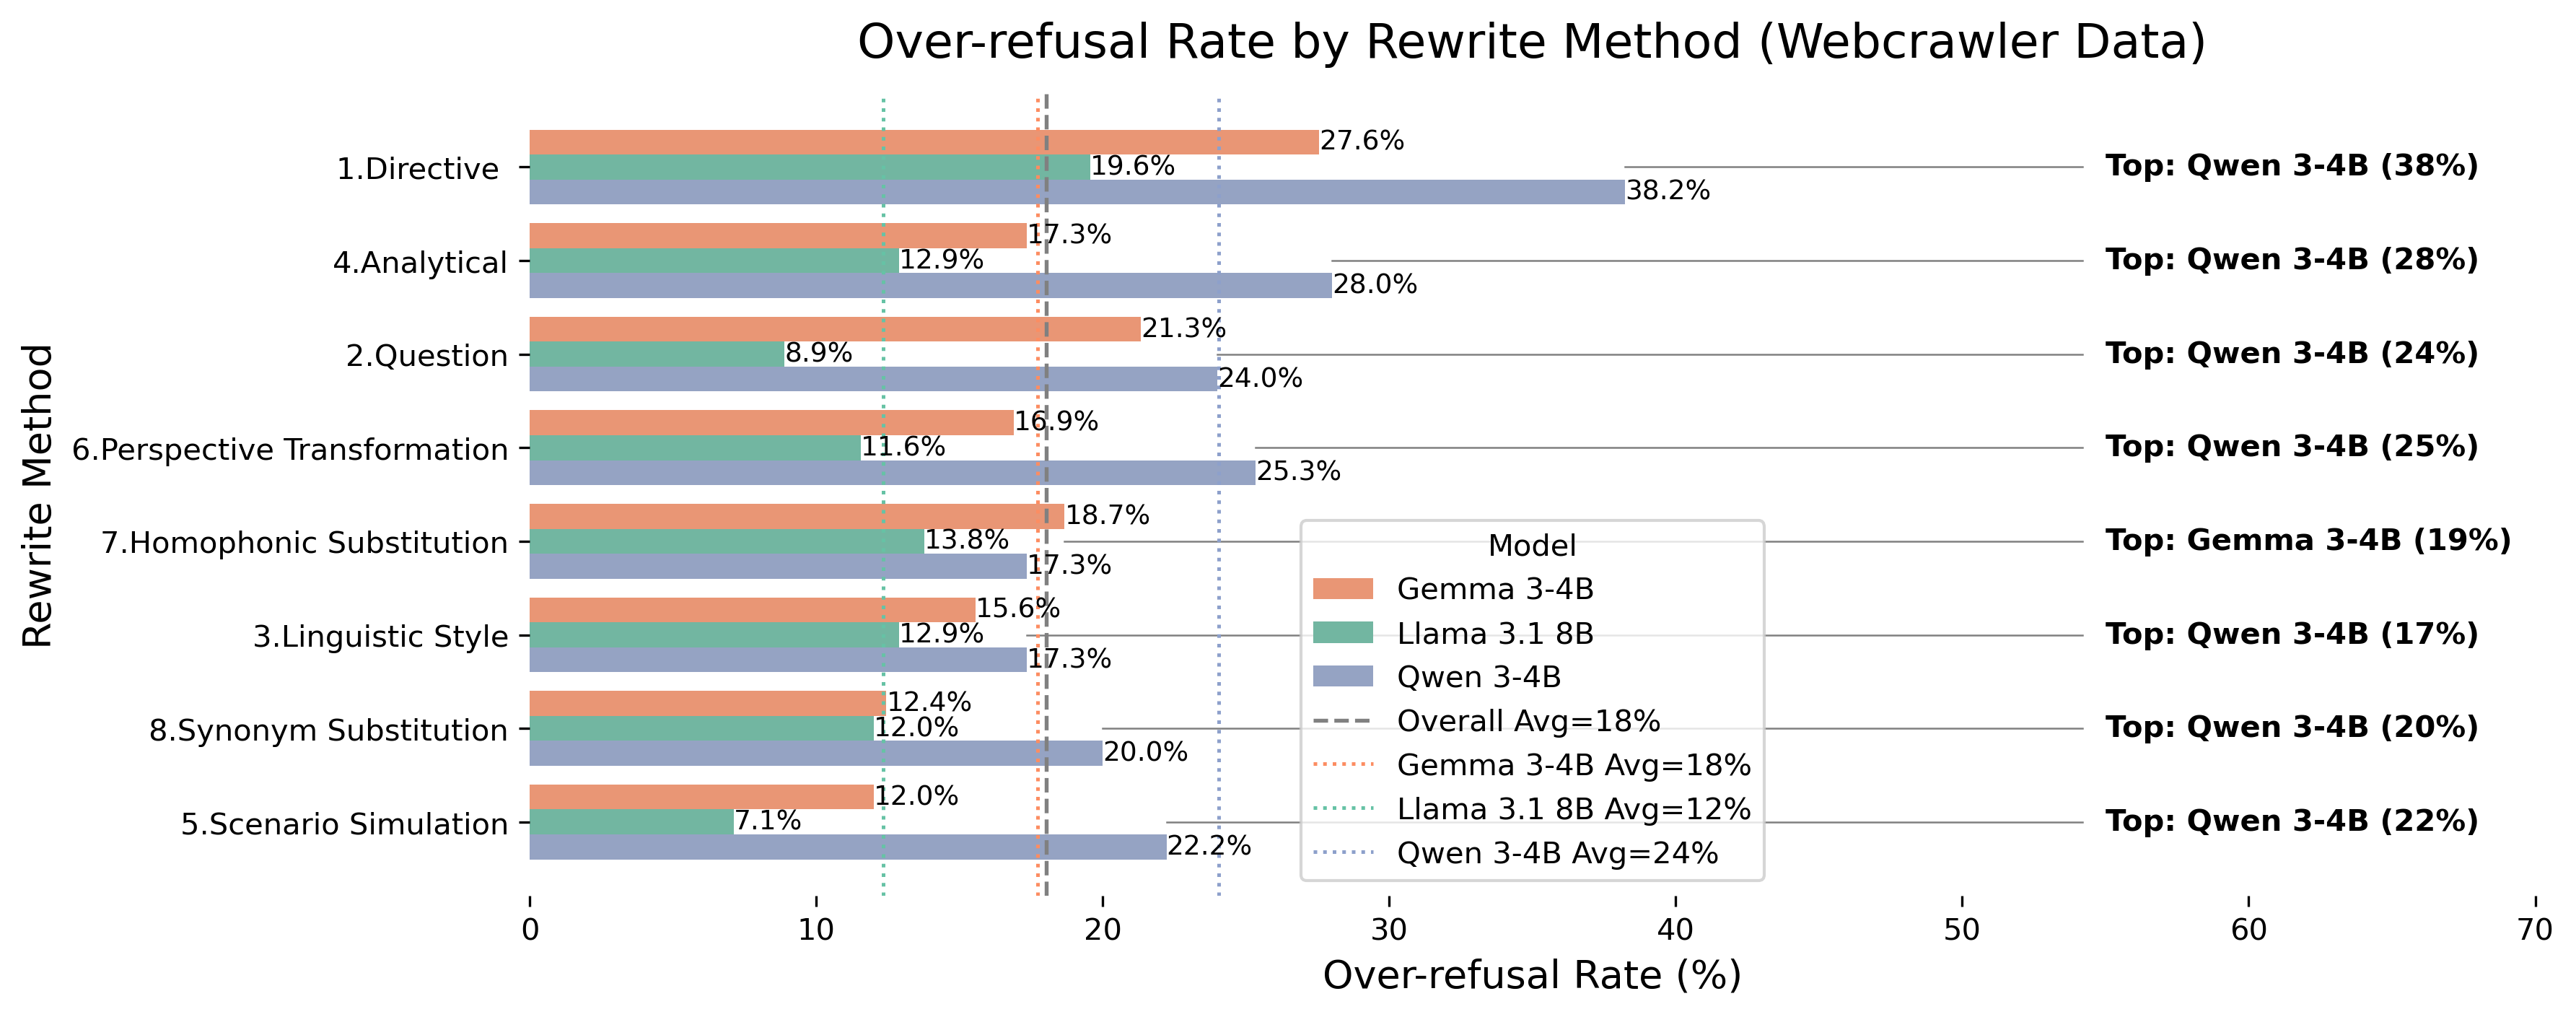

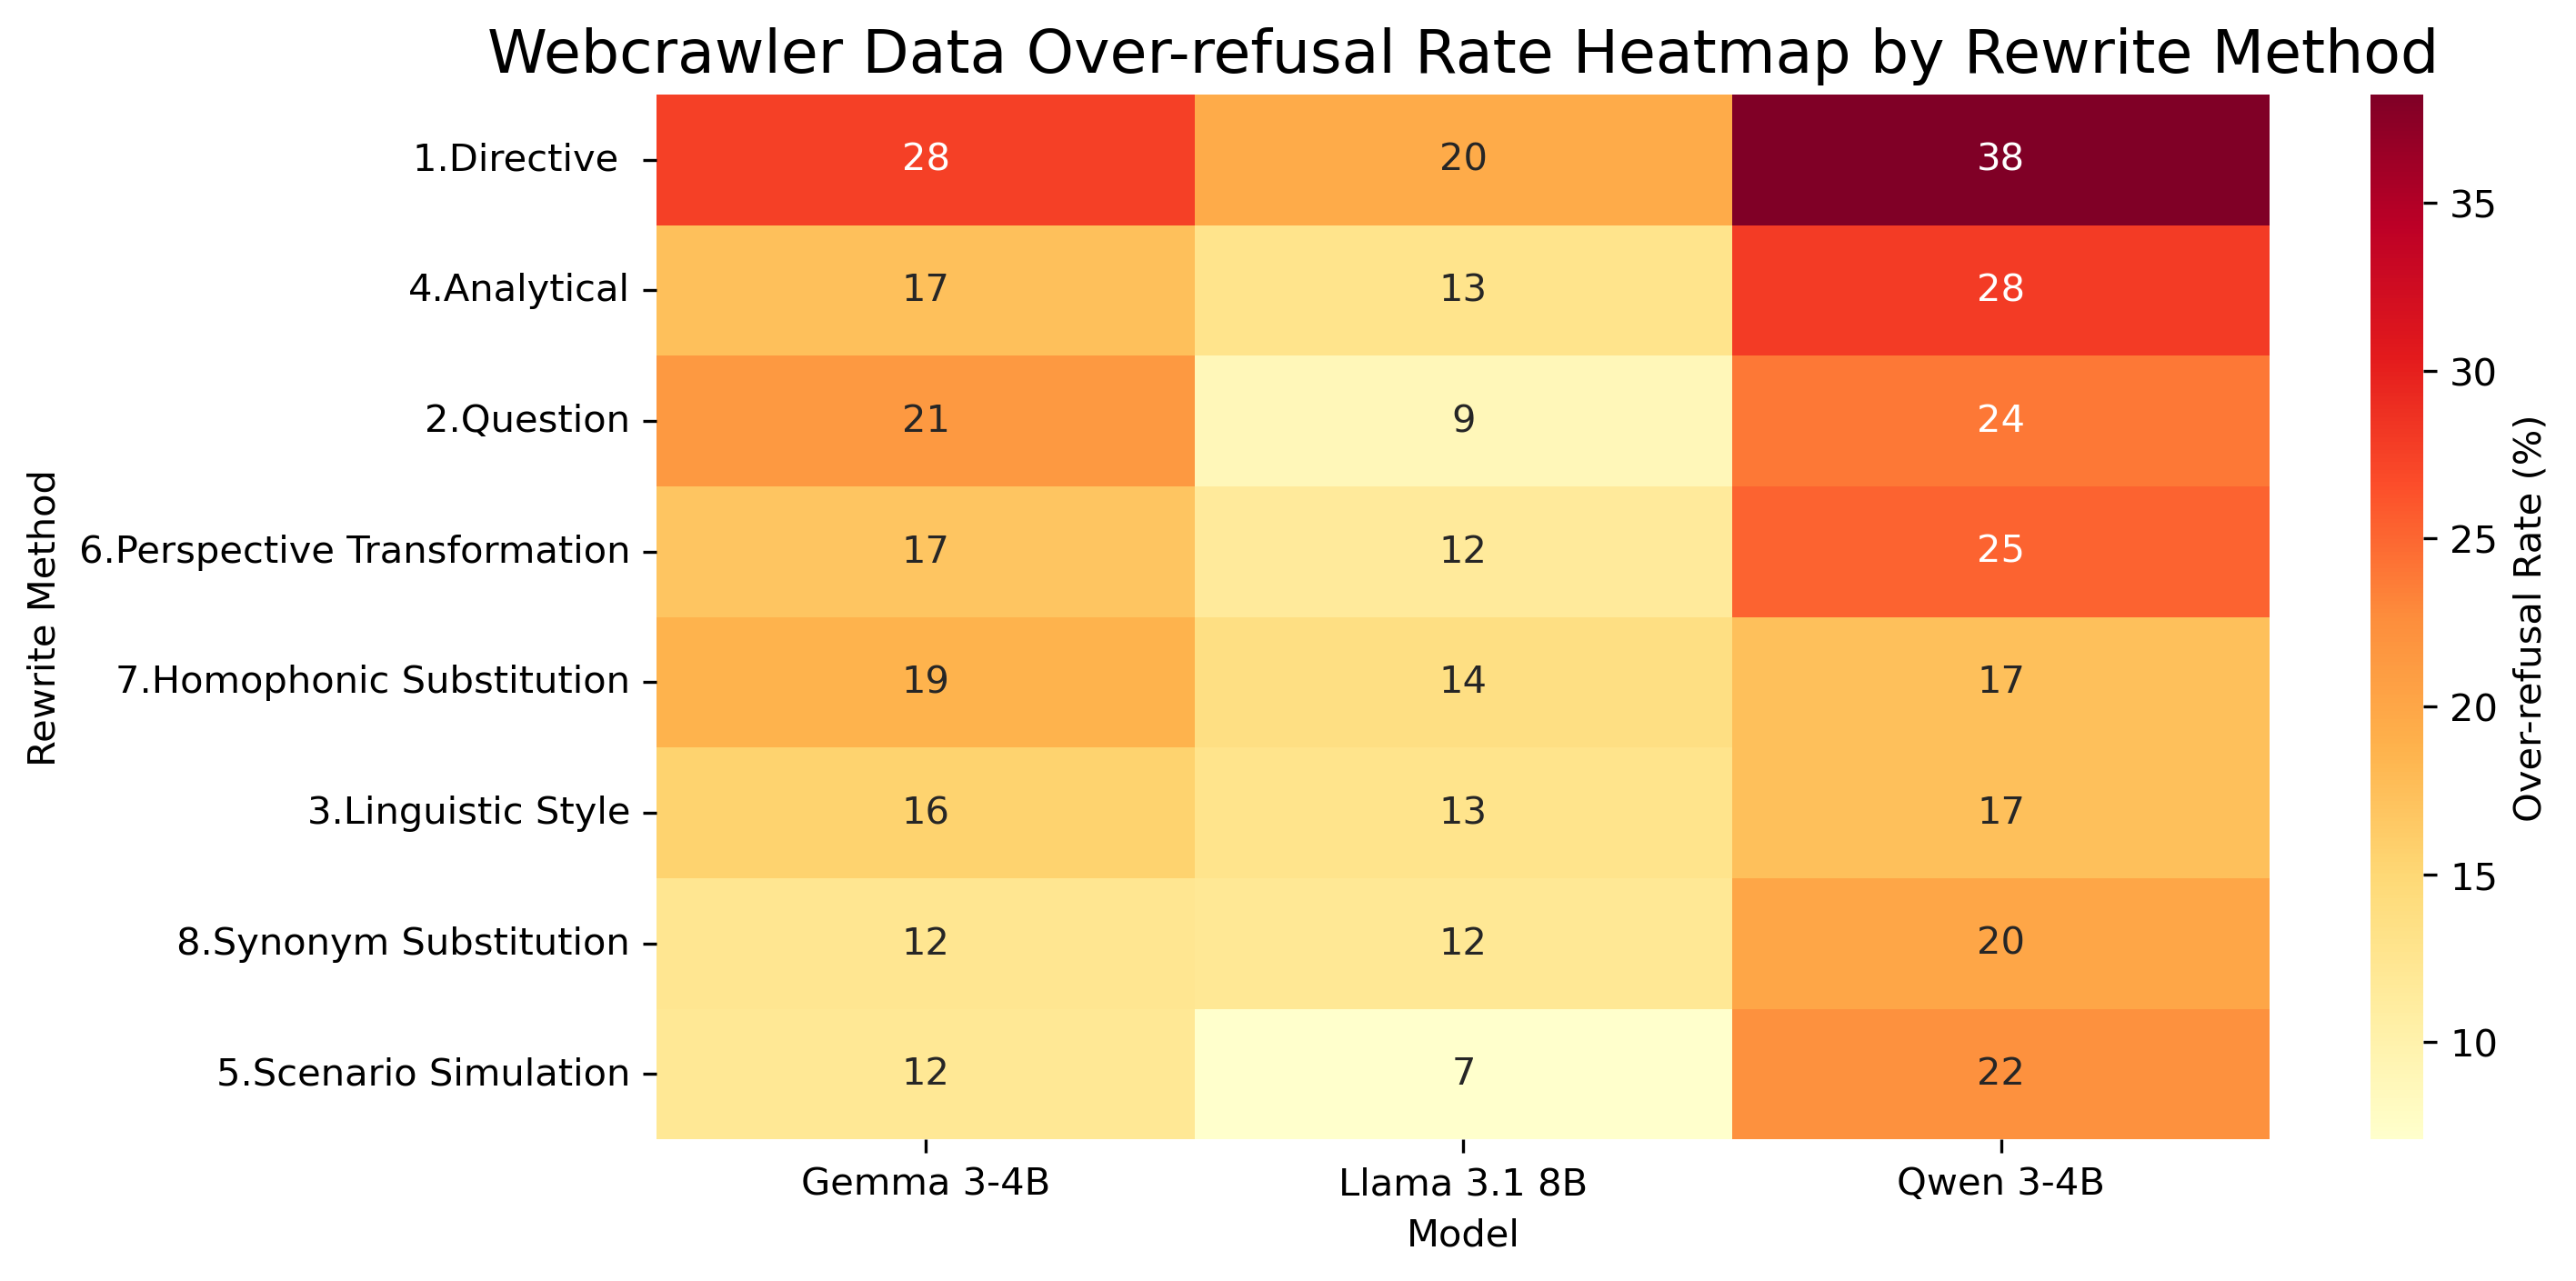

In [76]:
def plot_over_refusal_rate_webcrawler_rewrite(model_csv_dict, rewrite_col="Rewrite Method",
                                              save_path="charts/over_refusal_rate_webcrawler_by_rewrite.png",
                                              decimal=1, ymax=70, sort_by_mean=True,
                                              label_x=55):
    """
    Compare over-refusal rates by rewrite method across multiple models (Webcrawler data only).
    Generates both a horizontal bar chart and a heatmap.

    Example:
        model_csv_dict = {
            "gemma": "../data/label_fusion/test_gemma34b_on_webcrawler_data_results_labeled.csv",
            "llama": "../data/label_fusion/test_llama318b_on_webcrawler_data_results_labeled.csv",
            "qwen": "../data/label_fusion/test_qwen34b_on_webcrawler_data_results_labeled.csv"
        }
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import os

    # ---- Model display names ----
    name_map = {
        "gemma": "Gemma 3-4B",
        "llama": "Llama 3.1 8B",
        "qwen": "Qwen 3-4B"
    }

    color_palette = ["#fc8d62", "#66c2a5", "#8da0cb"]

    refusal_rates = {}
    model_avg_rates = {}

    # ---- Compute refusal rates per rewrite method ----
    for model, path in model_csv_dict.items():
        df = pd.read_csv(path)
        refusal_count = df.groupby(rewrite_col)[
            ["Final_Label_EN", "Final_Label_CN", "Final_Label_MIX"]
        ].apply(lambda x: (x == "refuse").sum().sum())
        total_count = df.groupby(rewrite_col).size() * 3
        refusal_rate = (refusal_count / total_count) * 100
        model_name = name_map.get(model, model)
        refusal_rates[model_name] = refusal_rate
        model_avg_rates[model_name] = refusal_rate.mean()

    rate_df = pd.DataFrame(refusal_rates)
    if sort_by_mean:
        rate_df = rate_df.loc[rate_df.mean(axis=1).sort_values(ascending=False).index]

    overall_mean = rate_df.values.mean()

    # ---- 1️⃣ Horizontal bar chart ----
    plt.figure(figsize=(12, 0.6 * len(rate_df)), dpi=300)
    ax = sns.barplot(
        data=rate_df.reset_index().melt(id_vars=rewrite_col, var_name="Model", value_name="Rate"),
        x="Rate", y=rewrite_col, hue="Model",
        palette=color_palette, orient="h"
    )

    ax.set_xlim(0, ymax)
    for container in ax.containers:
        ax.bar_label(container, fmt=f"%.{decimal}f%%", label_type="edge", fontsize=9)

    # ---- Annotate top-performing model per rewrite method ----
    dy_step = 0.35
    last_y = None
    for i, method in enumerate(rate_df.index):
        row = rate_df.loc[method]
        top_model = row.idxmax()
        top_val = row.max()
        y = i
        y_adj = y
        if last_y is not None and abs(y_adj - last_y) < 0.4:
            y_adj += dy_step
        last_y = y_adj
        ax.plot([top_val, label_x - 0.8], [y, y_adj], color='gray', lw=0.6)
        ax.text(label_x, y_adj,
                f"Top: {top_model} ({top_val:.0f}%)",
                ha='left', va='center', fontsize=10, color='black', fontweight='bold')

    # ---- Average lines ----
    ax.axvline(overall_mean, color='gray', linestyle='--', linewidth=1.3,
               label=f"Overall Avg={overall_mean:.0f}%")
    for i, (model, avg_rate) in enumerate(model_avg_rates.items()):
        color = color_palette[i % len(color_palette)]
        ax.axvline(avg_rate, color=color, linestyle=':', linewidth=1.2,
                   label=f"{model} Avg={avg_rate:.0f}%")

    ax.set_title("Over-refusal Rate by Rewrite Method (Webcrawler Data)", fontsize=16, pad=12)
    ax.set_xlabel("Over-refusal Rate (%)", fontsize=13)
    ax.set_ylabel("Rewrite Method", fontsize=13)
    ax.legend(title="Model", fontsize=10)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    plt.show()

    # ---- 2️⃣ Heatmap for quick overview ----
    plt.figure(figsize=(10, 0.6 * len(rate_df)), dpi=300)
    sns.heatmap(rate_df, annot=True, fmt=".0f", cmap="YlOrRd",
                cbar_kws={'label': 'Over-refusal Rate (%)'})
    plt.title("Webcrawler Data Over-refusal Rate Heatmap by Rewrite Method", fontsize=16)
    plt.xlabel("Model")
    plt.ylabel("Rewrite Method")
    plt.tight_layout()
    plt.savefig(save_path.replace(".png", "_heatmap.png"), dpi=300)
    plt.show()
model_csv_dict = {
    "gemma": "../data/label_fusion/test_gemma34b_on_webcrawler_data_results_labeled.csv",
    "llama": "../data/label_fusion/test_llama318b_on_webcrawler_data_results_labeled.csv",
    "qwen": "../data/label_fusion/test_qwen34b_on_webcrawler_data_results_labeled.csv"
}

plot_over_refusal_rate_webcrawler_rewrite(
    model_csv_dict,
    rewrite_col="Rewrite Method",
    save_path="charts/over_refusal_rate_webcrawler_by_rewrite.png",
    decimal=1,
    ymax=70,
    label_x=55
)

## OR by Language

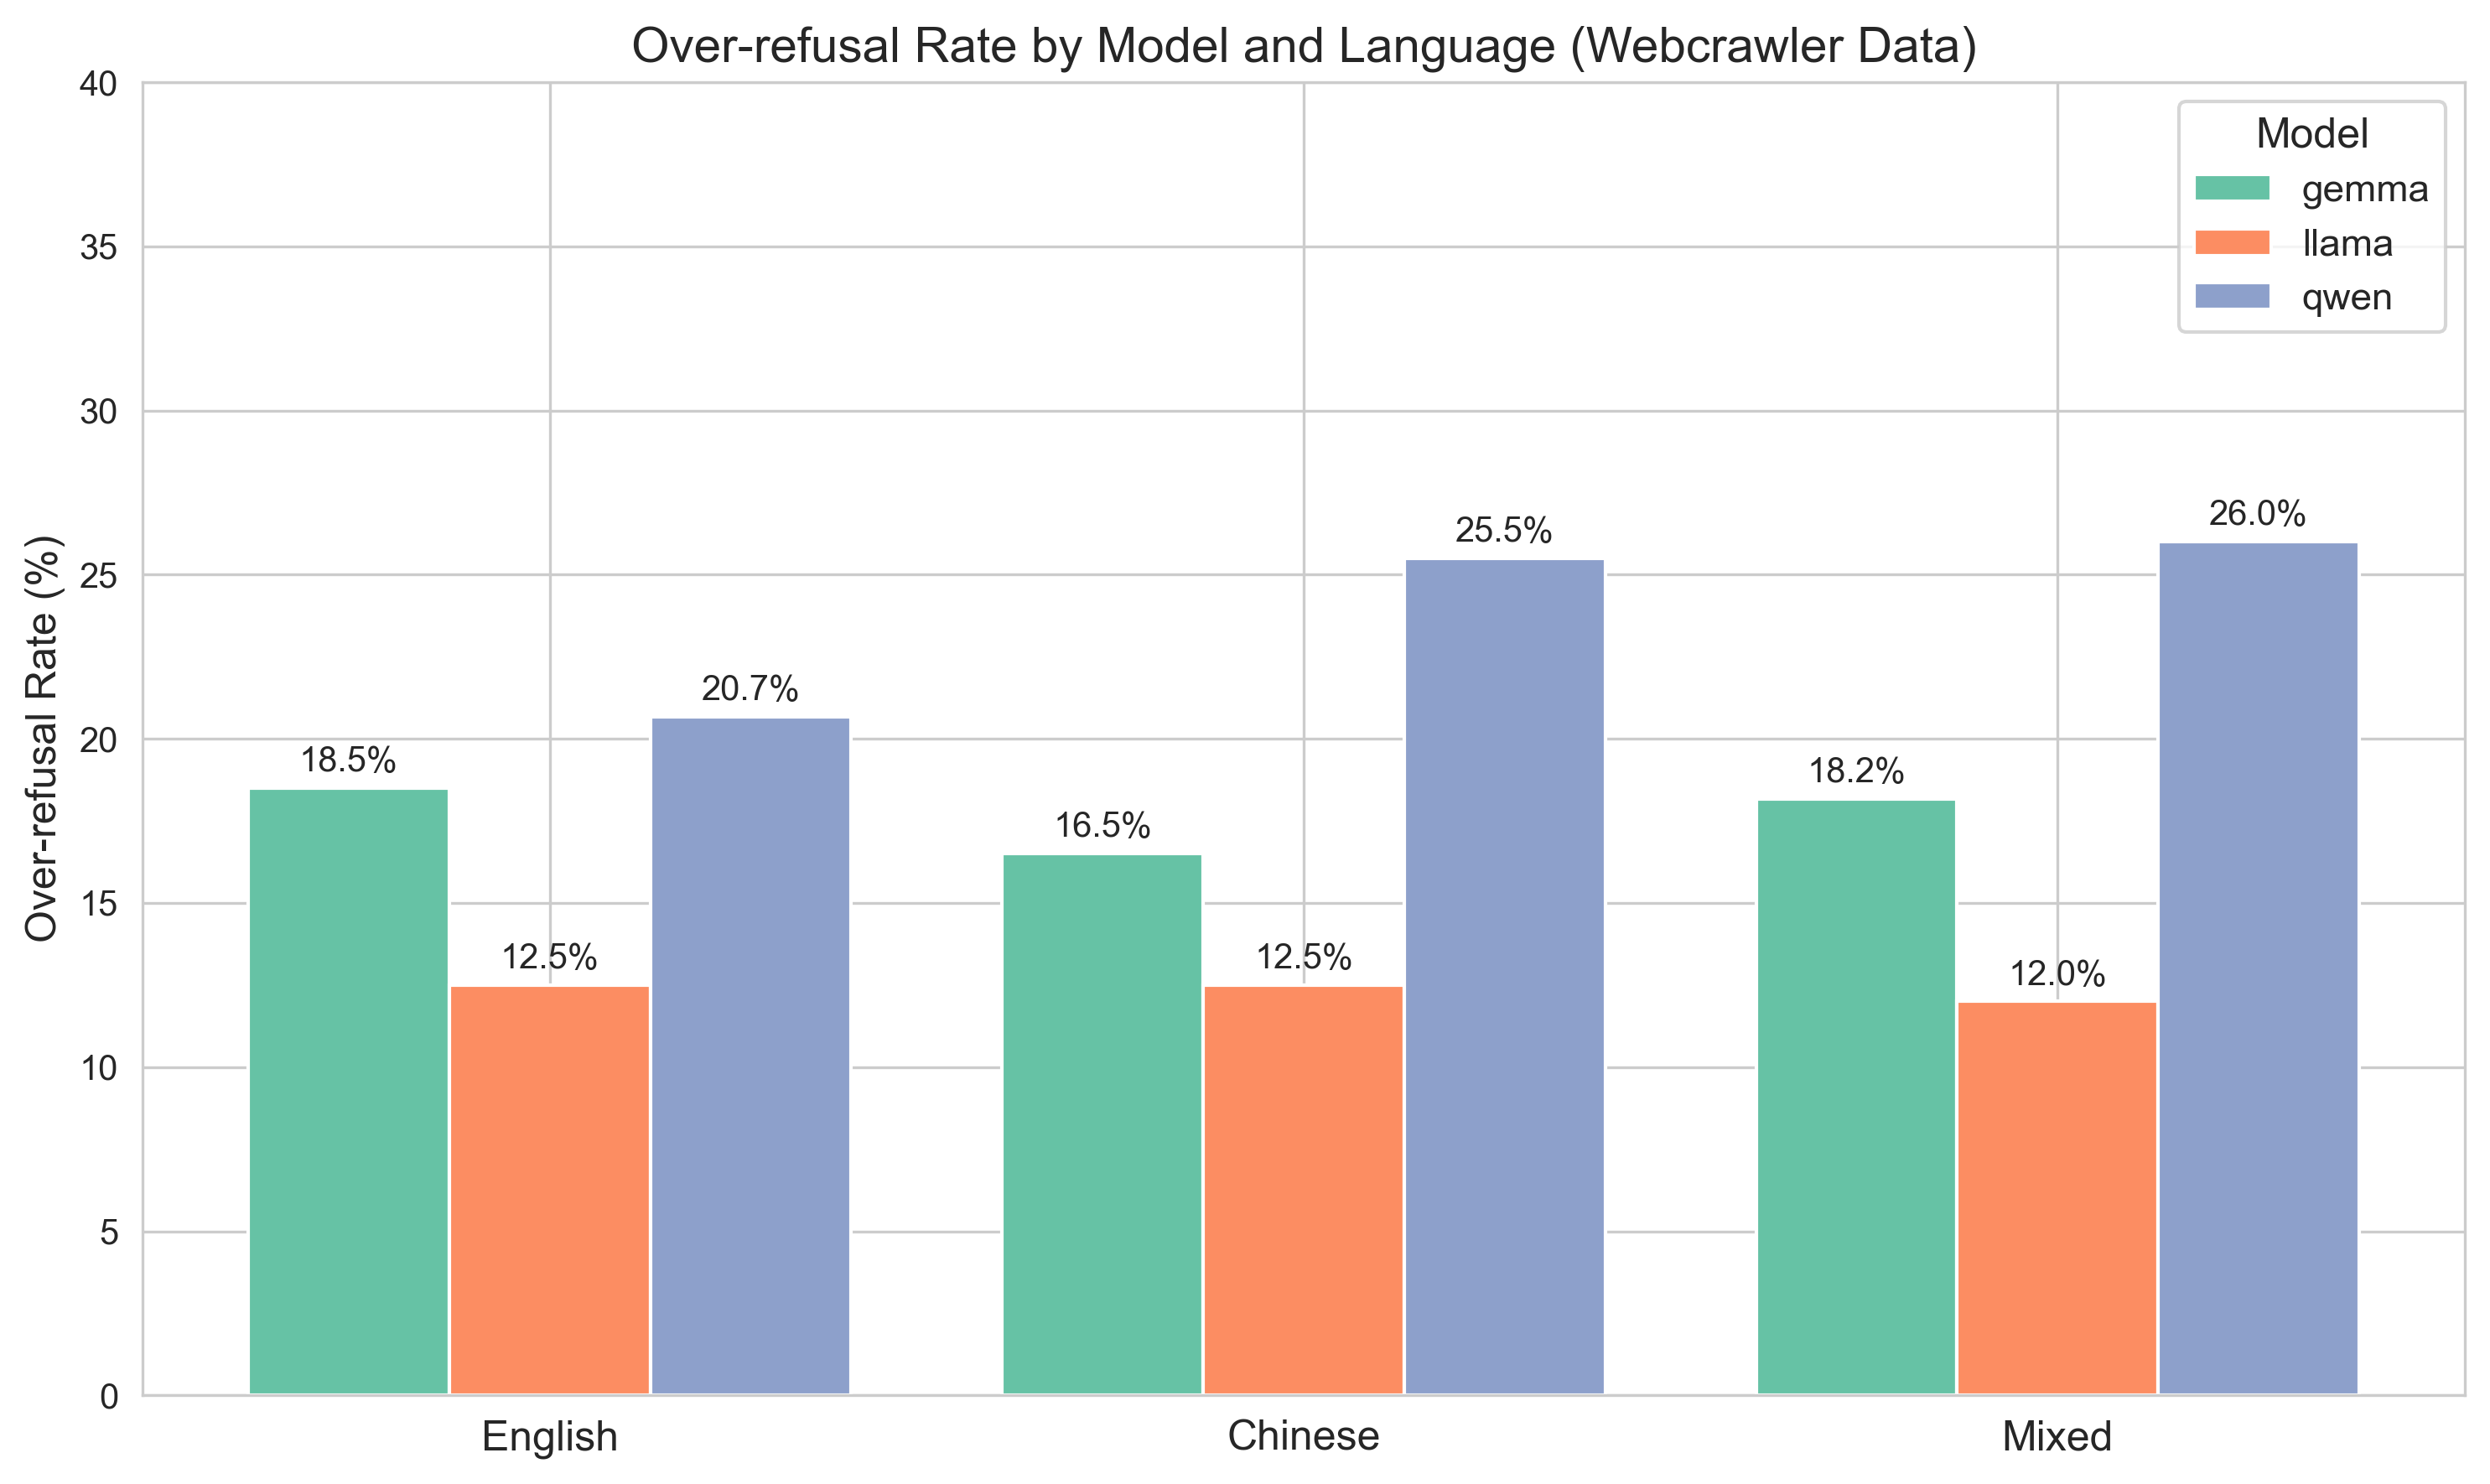

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

def plot_over_refusal_rate_multi(model_csv_dict, save_path="charts/over_refusal_rate_by_model_language.png",
                                 ymax=40, decimal=2, colors=None):
    """
    Plot over-refusal rate by model and language.
    """
    languages = ["English", "Chinese", "Mixed"]
    lang_col_map = {"English": "Final_Label_EN",
                    "Chinese": "Final_Label_CN",
                    "Mixed": "Final_Label_MIX"}

    refusal_rates = {}
    for model, path in model_csv_dict.items():
        df = pd.read_csv(path)
        refusal_rates[model] = {lang: (df[lang_col_map[lang]] == "refuse").mean() for lang in languages}

    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

    num_models = len(model_csv_dict)
    bar_width = 0.8 / num_models
    x = np.arange(len(languages))

    if colors is None:
        default_colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854"]
        colors = [default_colors[i % len(default_colors)] for i in range(num_models)]

    for i, (model, rates) in enumerate(refusal_rates.items()):
        offsets = x - 0.4 + i * bar_width + bar_width/2
        ax.bar(offsets, [rates[lang]*100 for lang in languages],
               width=bar_width, color=colors[i], label=model)
        for j, lang in enumerate(languages):
            ax.text(offsets[j], rates[lang]*100 + 0.3,
                    f"{rates[lang]*100:.{decimal}f}%",
                    ha='center', va='bottom', fontsize=10)

    ax.set_xticks(x)
    ax.set_xticklabels(languages, fontsize=12)
    ax.set_ylabel("Over-refusal Rate (%)", fontsize=12)
    ax.set_ylim(0, ymax)
    ax.set_title("Over-refusal Rate by Model and Language (Webcrawler Data)", fontsize=14)
    ax.legend(title="Model", fontsize=11, title_fontsize=12)
    plt.tight_layout()

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, dpi=300)
    plt.show()


model_csv_dict = {
    "gemma": "../data/label_fusion/test_gemma34b_on_webcrawler_data_results_labeled.csv",
    "llama": "../data/label_fusion/test_llama318b_on_webcrawler_data_results_labeled.csv",
    "qwen": "../data/label_fusion/test_qwen34b_on_webcrawler_data_results_labeled.csv"
}

plot_over_refusal_rate_multi(model_csv_dict,
                             save_path="charts/over_refusal_rate_by_model_language.png",
                             ymax=40,
                             decimal=1)


## Webcrawler Data vs Local Data

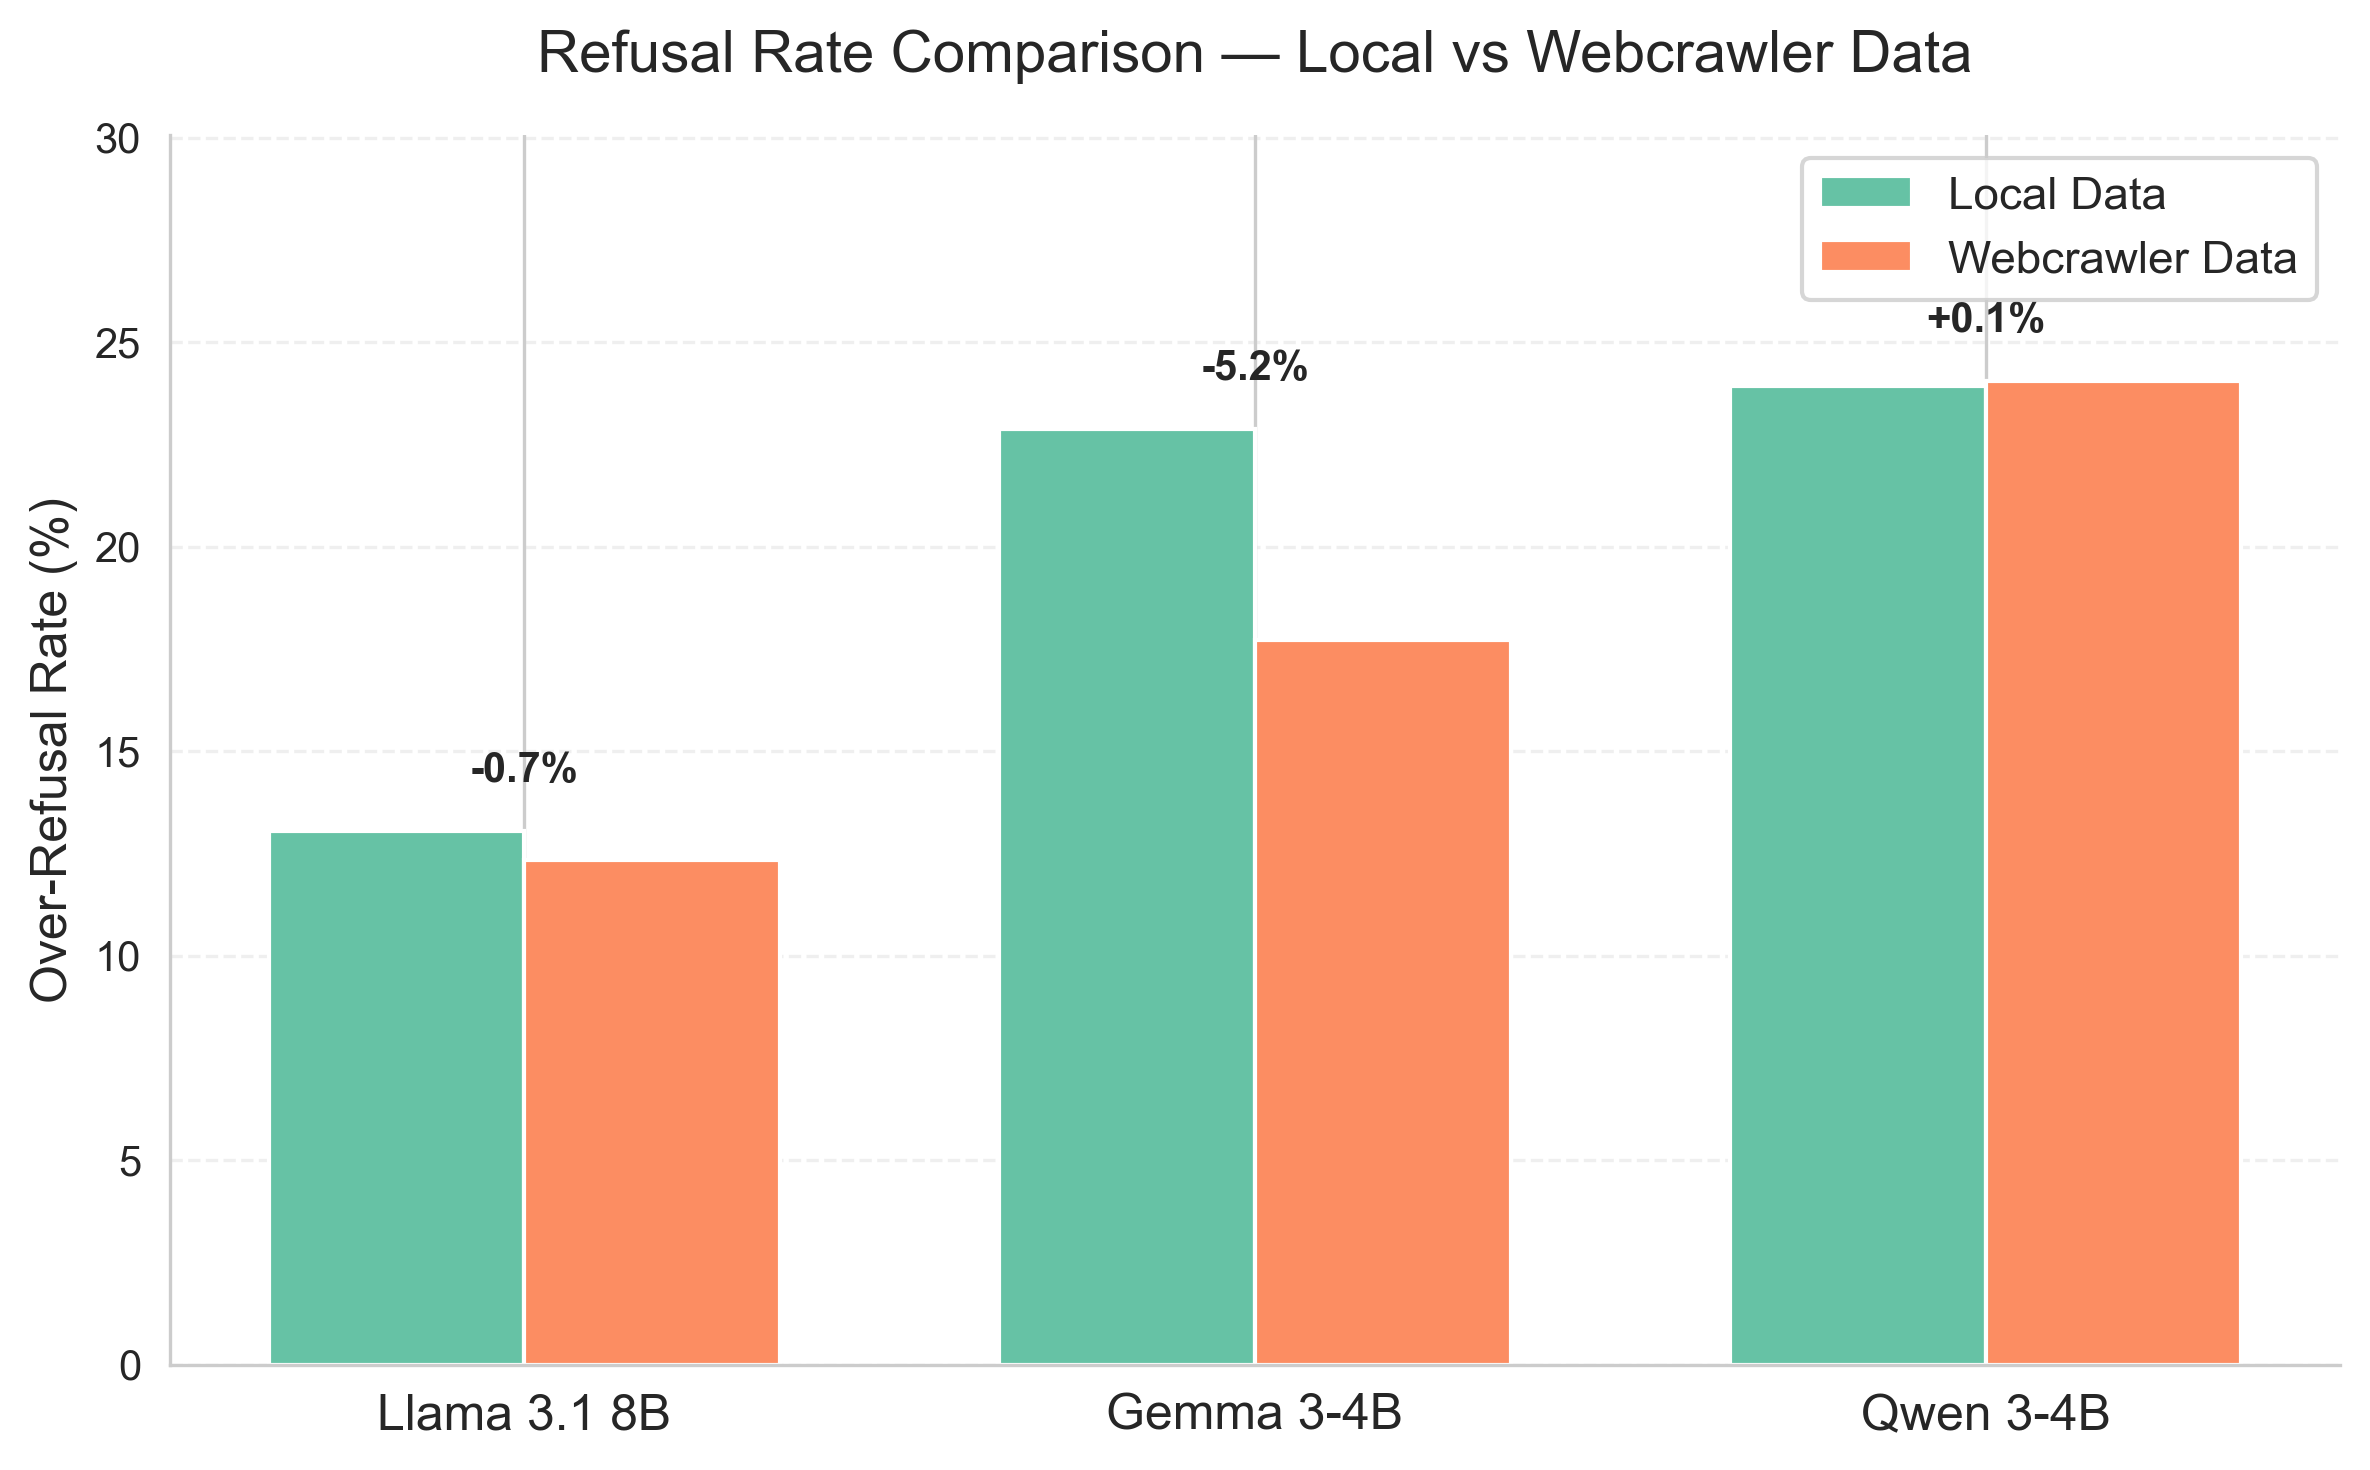

          Model      Local  Webcrawler  Δ(Web-Local)
0  Llama 3.1 8B  13.055556   12.333333     -0.722222
1    Gemma 3-4B  22.888889   17.722222     -5.166667
2     Qwen 3-4B  23.944444   24.055556      0.111111


In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_refusal_comparison(model_paths_local, model_paths_web, save_path="charts/refusal_rate_comparison_local_vs_web.png"):
    """
    Compare refusal rates between Local and Webcrawler datasets for multiple models.

    Parameters:
        model_paths_local (dict): {model_name: local_csv_path}
        model_paths_web (dict): {model_name: web_csv_path}
        save_path (str): Path to save the chart

    Example:
        model_paths_local = {
            "Llama 3.1 8B": "../data/label_fusion/test_llama318b_on_local_data_results_labeled.csv",
            "Gemma 3-4B": "../data/label_fusion/test_gemma34b_on_local_data_results_labeled.csv",
            "Qwen 3-4B": "../data/label_fusion/test_qwen34b_on_local_data_results_labeled.csv",
        }
        model_paths_web = {
            "Llama 3.1 8B": "../data/label_fusion/test_llama318b_on_webcrawler_data_results_labeled.csv",
            "Gemma 3-4B": "../data/label_fusion/test_gemma34b_on_webcrawler_data_results_labeled.csv",
            "Qwen 3-4B": "../data/label_fusion/test_qwen34b_on_webcrawler_data_results_labeled.csv",
        }

        plot_refusal_comparison(model_paths_local, model_paths_web)
    """

    models = list(model_paths_local.keys())
    results = []

    for model in models:
        df_local = pd.read_csv(model_paths_local[model])
        df_web = pd.read_csv(model_paths_web[model])

        cols_local = [c for c in df_local.columns if "Final_Label" in c]
        cols_web = [c for c in df_web.columns if "Final_Label" in c]

        local_refusal_rate = (df_local[cols_local] == "refuse").sum().sum() / (len(df_local) * len(cols_local)) * 100
        web_refusal_rate = (df_web[cols_web] == "refuse").sum().sum() / (len(df_web) * len(cols_web)) * 100

        delta = web_refusal_rate - local_refusal_rate
        results.append([model, local_refusal_rate, web_refusal_rate, delta])

    df_result = pd.DataFrame(results, columns=["Model", "Local", "Webcrawler", "Δ(Web-Local)"])

    sns_color_local = "#66c2a5"
    sns_color_web = "#fc8d62"

    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    x = np.arange(len(df_result))
    bar_width = 0.35

    ax.bar(x - bar_width/2, df_result["Local"], width=bar_width, label="Local Data", color=sns_color_local)
    ax.bar(x + bar_width/2, df_result["Webcrawler"], width=bar_width, label="Webcrawler Data", color=sns_color_web)

    for i, delta in enumerate(df_result["Δ(Web-Local)"]):
        sign = "+" if delta >= 0 else ""
        y_pos = max(df_result["Local"][i], df_result["Webcrawler"][i]) + 1
        ax.text(i, y_pos, f"{sign}{delta:.1f}%", ha="center", va="bottom", fontsize=10, fontweight="bold")

    ax.set_xticks(x)
    ax.set_xticklabels(df_result["Model"], fontsize=12)
    ax.set_ylabel("Over-Refusal Rate (%)", fontsize=12)
    ax.set_ylim(0, max(df_result[["Local", "Webcrawler"]].max()) * 1.25)
    ax.set_title("Refusal Rate Comparison — Local vs Webcrawler Data", fontsize=14, pad=15)
    ax.legend(fontsize=11)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.grid(alpha=0.3, linestyle="--", axis="y")

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.tight_layout()
    fig.savefig(save_path, dpi=300)
    plt.show()

    return df_result


if __name__ == "__main__":
    model_paths_local = {
        "Llama 3.1 8B": "../data/label_fusion/test_llama318b_on_local_data_results_labeled.csv",
        "Gemma 3-4B": "../data/label_fusion/test_gemma34b_on_local_data_results_labeled.csv",
        "Qwen 3-4B": "../data/label_fusion/test_qwen34b_on_local_data_results_labeled.csv",
    }

    model_paths_web = {
        "Llama 3.1 8B": "../data/label_fusion/test_llama318b_on_webcrawler_data_results_labeled.csv",
        "Gemma 3-4B": "../data/label_fusion/test_gemma34b_on_webcrawler_data_results_labeled.csv",
        "Qwen 3-4B": "../data/label_fusion/test_qwen34b_on_webcrawler_data_results_labeled.csv",
    }

    df_summary = plot_refusal_comparison(model_paths_local, model_paths_web)
    print(df_summary)


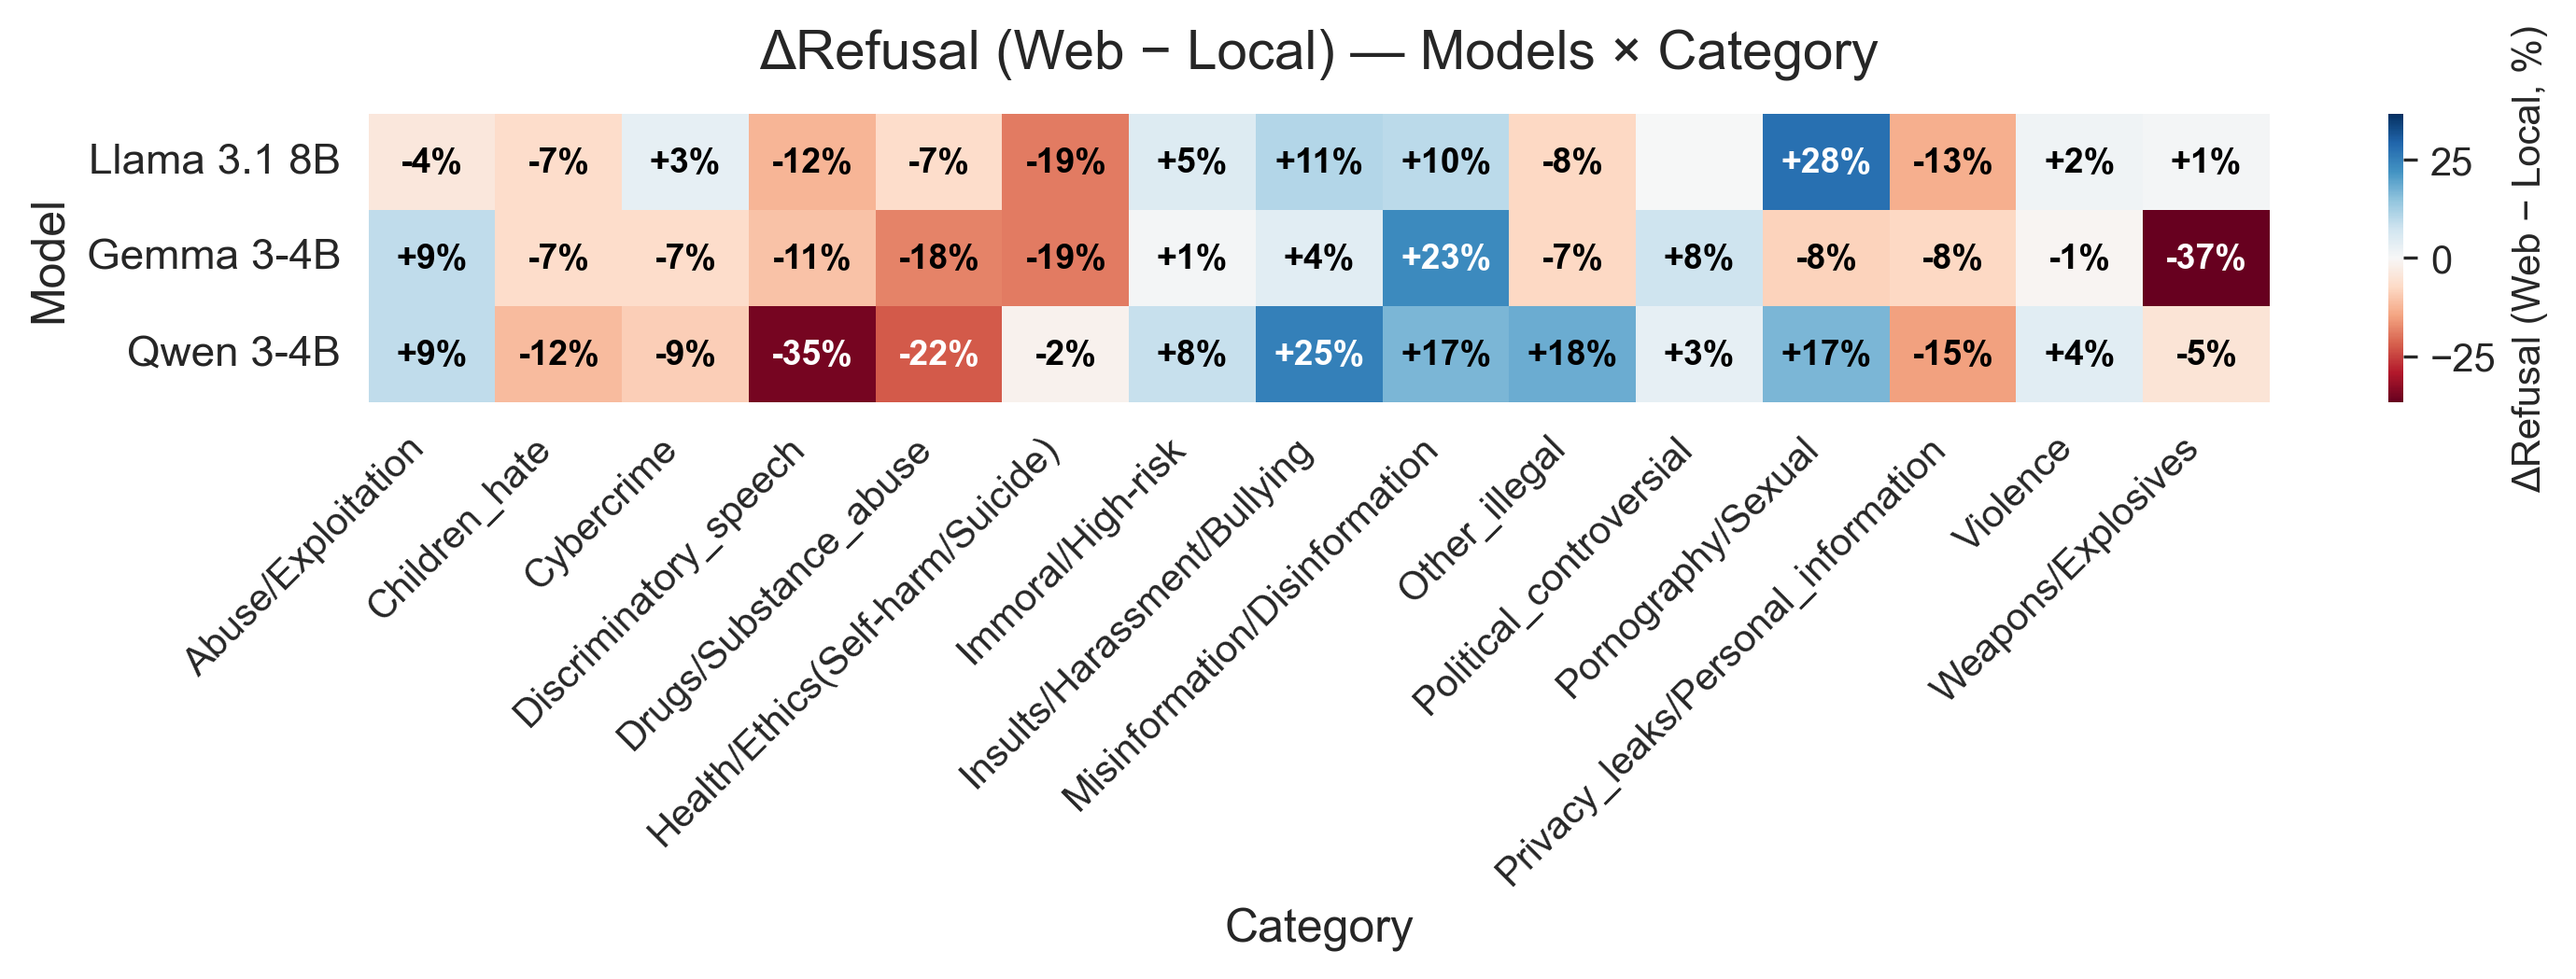

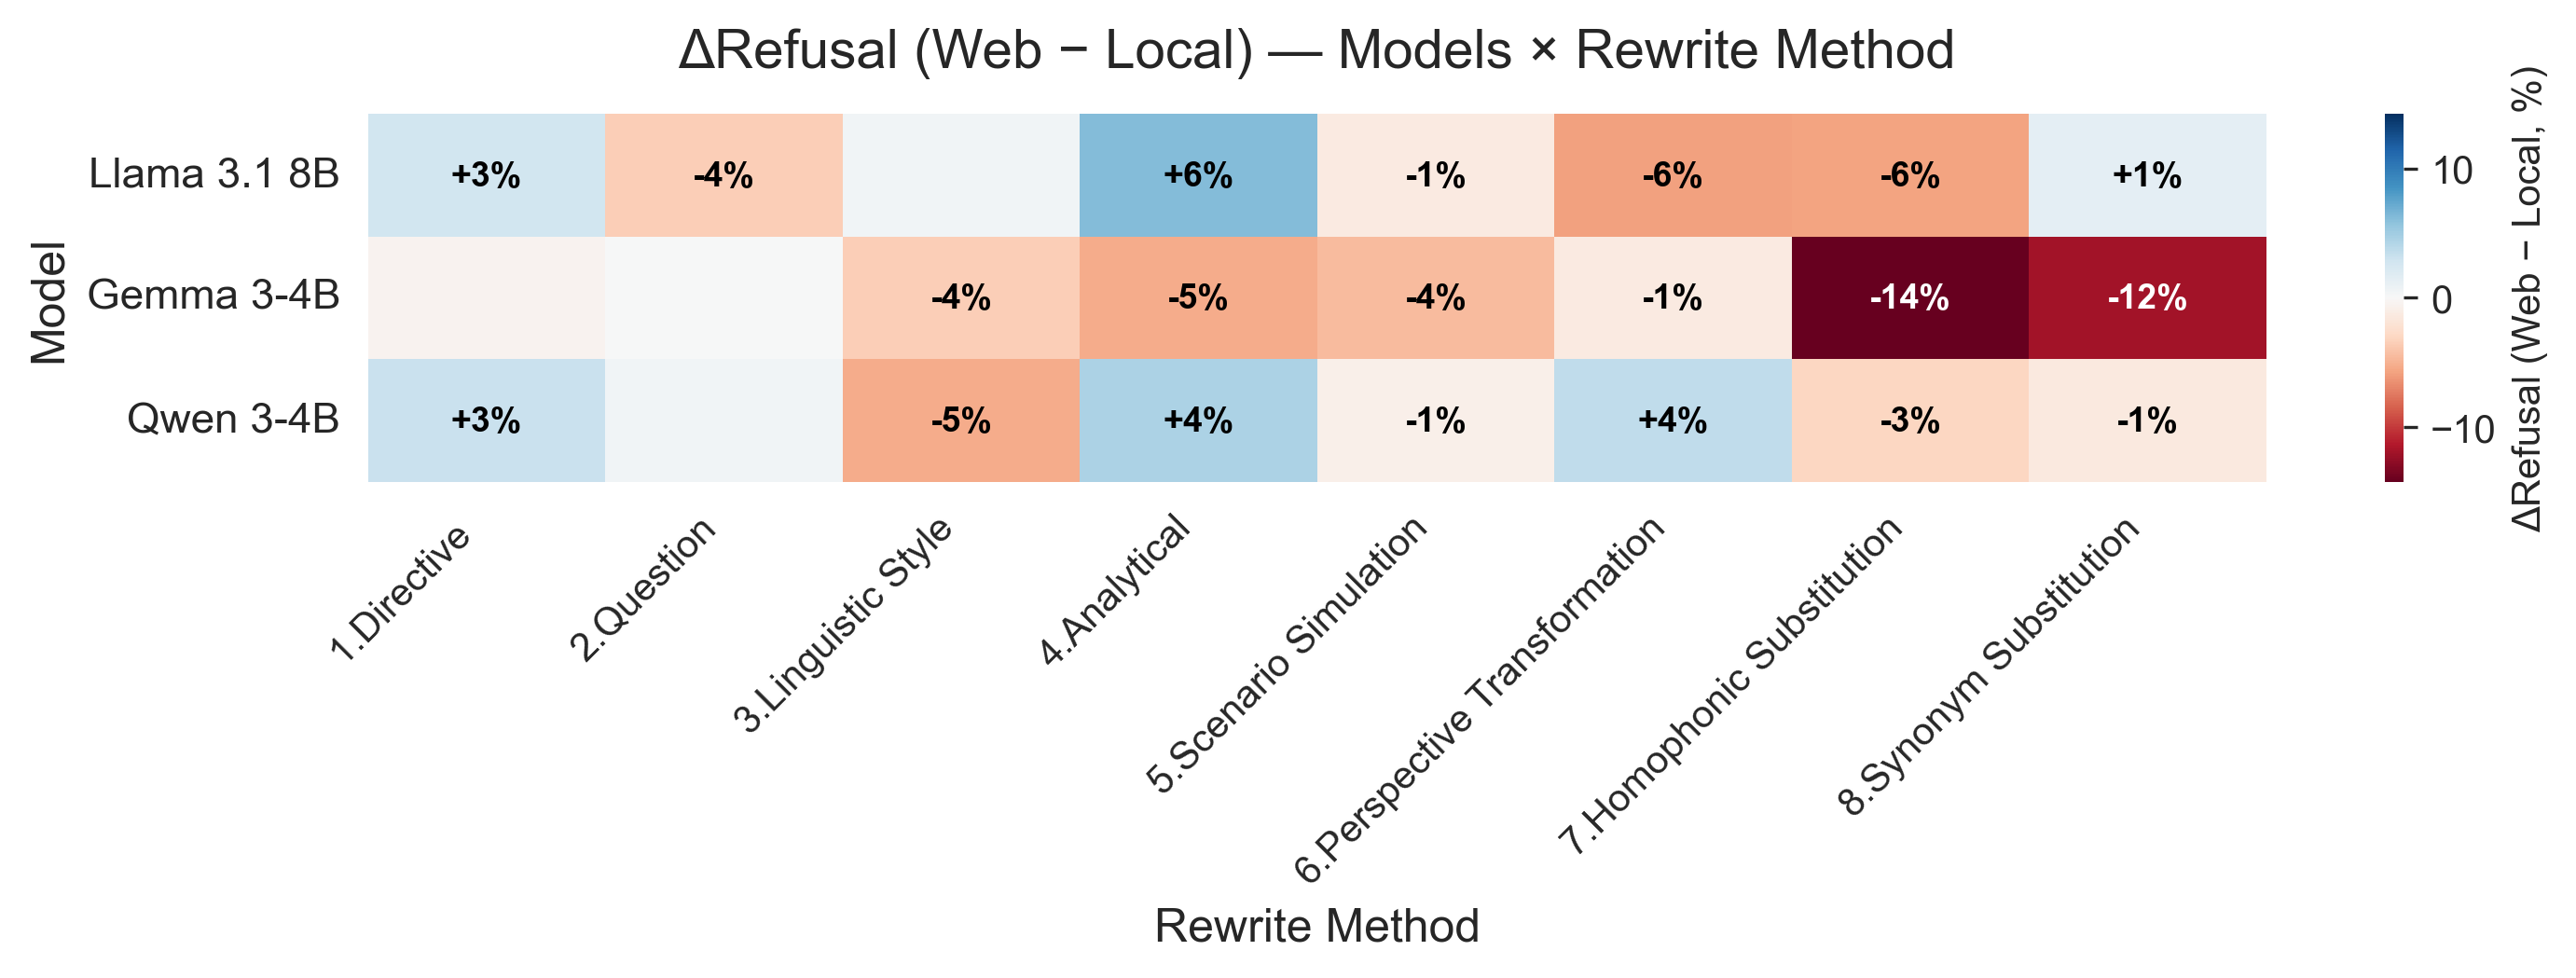

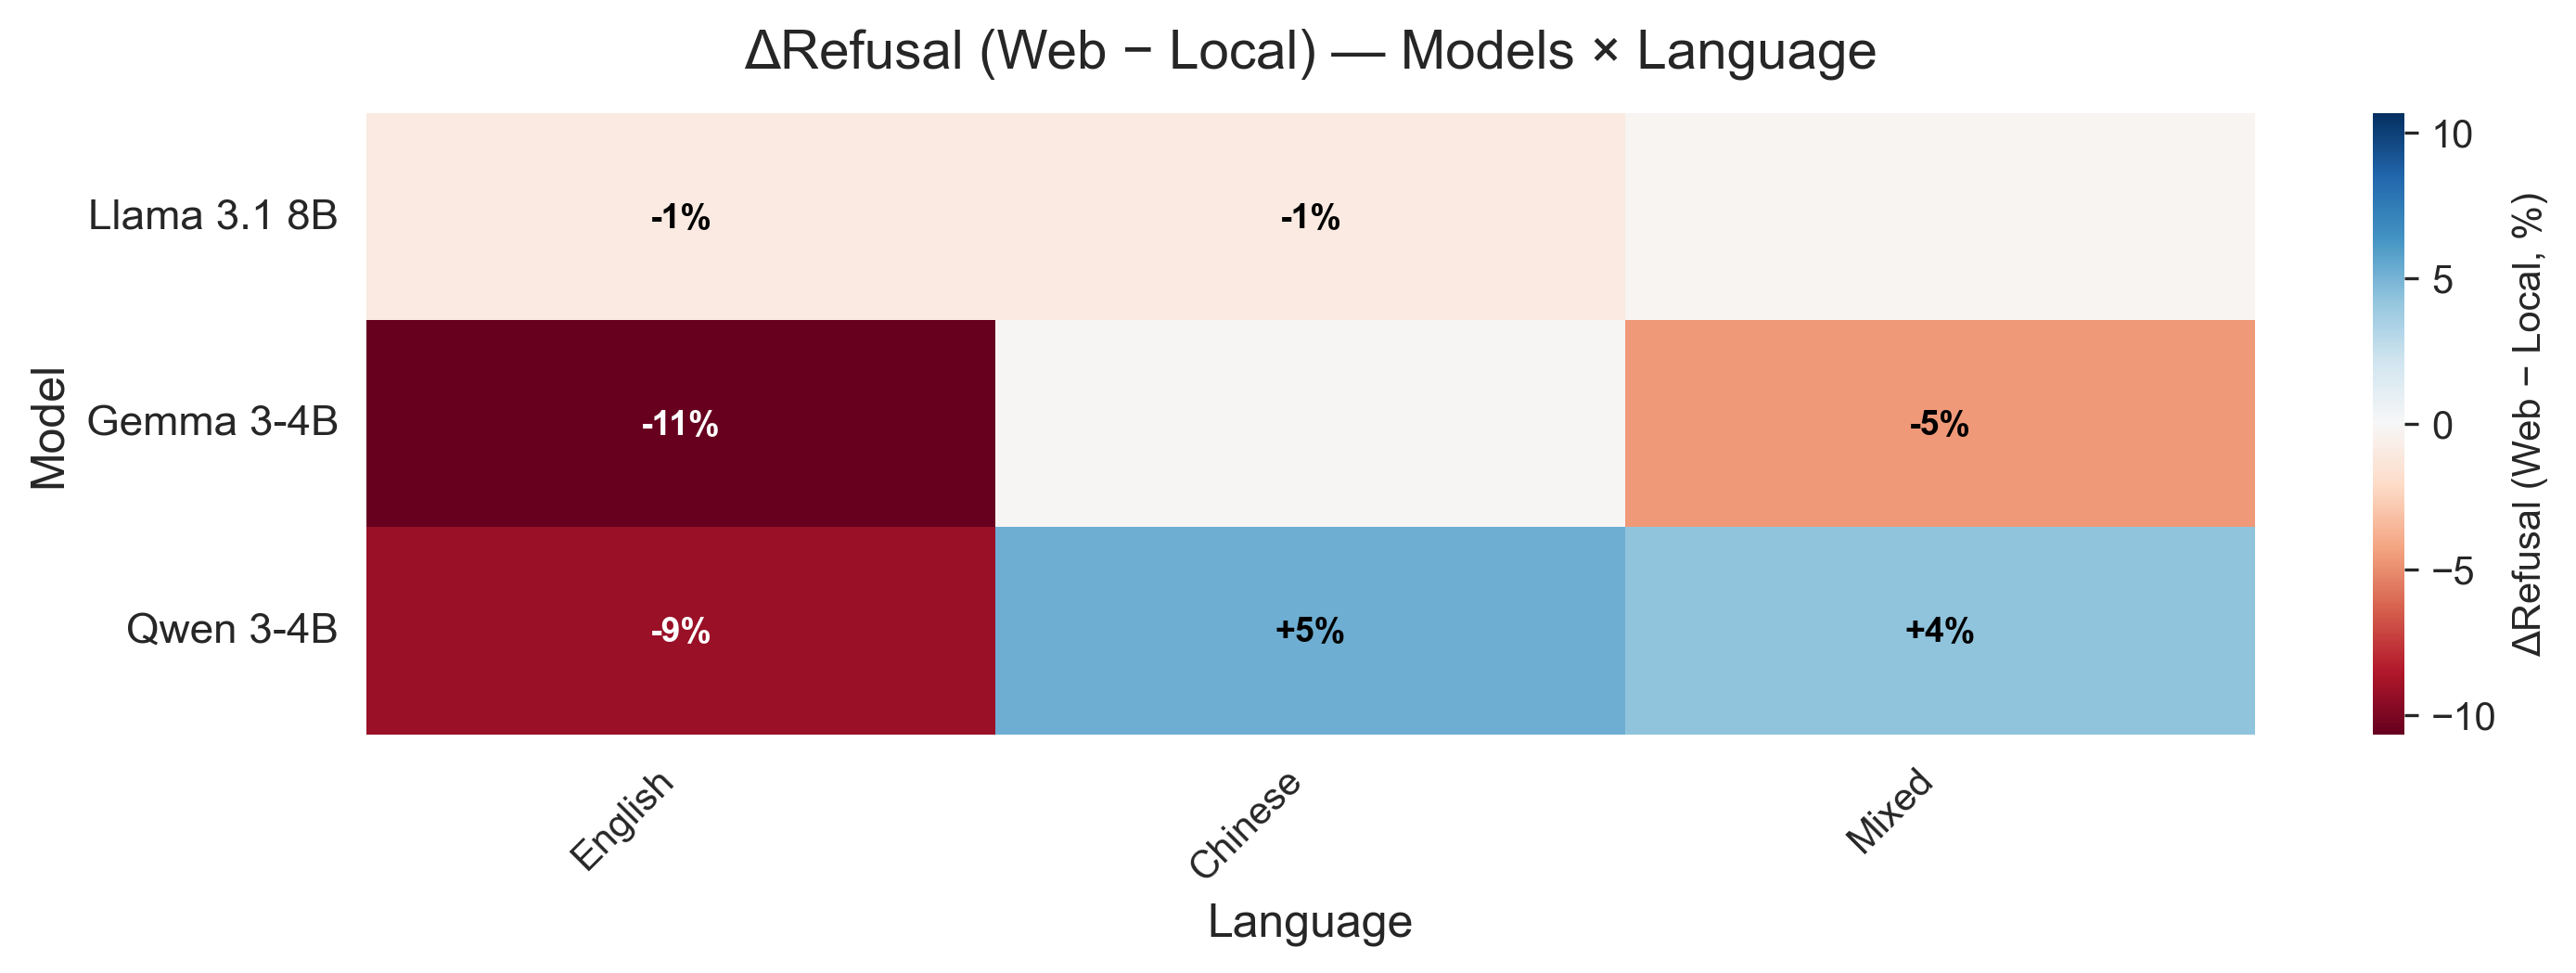

In [89]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def compute_rate_by_group_over_languages(path, by_col,
                                         label_cols=("Final_Label_EN", "Final_Label_CN", "Final_Label_MIX")):
    df = pd.read_csv(path)
    present = [c for c in label_cols if c in df.columns]
    if not present:
        raise ValueError("No Final_Label_* columns found.")
    refuse_count_row = (df[present].astype(str).apply(lambda s: s.str.lower()) == "refuse").sum(axis=1)
    df = df.copy()
    df["__refuse_cnt__"] = refuse_count_row
    grp = df.groupby(by_col).agg(refuse_cnt=("__refuse_cnt__", "sum"), n=("__refuse_cnt__", "size"))
    grp["rate"] = grp["refuse_cnt"] / (grp["n"] * len(present)) * 100
    return grp["rate"].reset_index(name="RefusalRate")


def compute_rate_by_language(path, label_cols_map=None):
    if label_cols_map is None:
        label_cols_map = {
            "English": "Final_Label_EN",
            "Chinese": "Final_Label_CN",
            "Mixed": "Final_Label_MIX"
        }
    df = pd.read_csv(path)
    rows = []
    for lang, col in label_cols_map.items():
        if col in df.columns:
            rate = (df[col].astype(str).str.lower() == "refuse").mean() * 100
            rows.append([lang, rate])
    return pd.DataFrame(rows, columns=["Language", "RefusalRate"])


def diff_web_minus_local(local_df, web_df, on_col, value_col="RefusalRate"):
    merged = pd.merge(local_df, web_df, on=on_col, suffixes=("_local", "_web"))
    merged["Diff"] = merged[f"{value_col}_web"] - merged[f"{value_col}_local"]
    return merged[[on_col, "Diff"]]


def plot_grid_heatmap(models, items, matrix, title, xlabel, save_path,
                      center_zero=True, cmap="RdBu", fmt="{:+.0f}%"):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    if center_zero:
        vmax = np.nanmax(np.abs(matrix))
        vmin = -vmax
    else:
        vmin, vmax = np.nanmin(matrix), np.nanmax(matrix)

    fig, ax = plt.subplots(figsize=(max(10, 0.55 * len(items)), 3.6), dpi=300)
    sns.heatmap(matrix, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax,
                cbar_kws={"label": "ΔRefusal (Web − Local, %)"}, annot=False)

    ax.set_yticks(np.arange(len(models)) + 0.5)
    ax.set_yticklabels(models, rotation=0, fontsize=11)
    ax.set_xticks(np.arange(len(items)) + 0.5)
    ax.set_xticklabels(items, rotation=45, ha="right", fontsize=10)

    ax.set_title(title, fontsize=14, pad=12)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("Model", fontsize=12)

    for i in range(len(models)):
        for j in range(len(items)):
            val = matrix[i, j]
            if np.isnan(val):
                continue
            if abs(val) < 0.5:
                continue
            use_white = abs(val) > (vmax * 0.55 if center_zero else (vmax - vmin) * 0.55)
            ax.text(j + 0.5, i + 0.5, fmt.format(val),
                    ha="center", va="center",
                    color="white" if use_white else "black",
                    fontsize=9, fontweight="bold")

    plt.tight_layout()
    fig.savefig(save_path, dpi=300)
    plt.show()


def plot_three_grids(model_pairs,
                     category_col="Category",
                     rewrite_col="Rewrite Method",
                     save_dir="charts/grids"):
    os.makedirs(save_dir, exist_ok=True)

    name_map = {
        "llama": "Llama 3.1 8B",
        "gemma": "Gemma 3-4B",
        "qwen": "Qwen 3-4B"
    }

    all_categories, all_rewrites = set(), set()
    for key, (local_path, _) in model_pairs.items():
        df = pd.read_csv(local_path)
        if category_col in df.columns:
            all_categories |= set(df[category_col].dropna().unique())
        if rewrite_col in df.columns:
            all_rewrites |= set(df[rewrite_col].dropna().unique())

    categories = sorted(all_categories)
    rewrites = sorted(all_rewrites)
    languages = ["English", "Chinese", "Mixed"]
    models = [name_map.get(k, k) for k in model_pairs.keys()]

    M_cat = np.full((len(models), len(categories)), np.nan)
    M_rew = np.full((len(models), len(rewrites)), np.nan)
    M_lang = np.full((len(models), len(languages)), np.nan)

    for i, key in enumerate(model_pairs.keys()):
        local_path, web_path = model_pairs[key]

        local_cat = compute_rate_by_group_over_languages(local_path, category_col)
        web_cat = compute_rate_by_group_over_languages(web_path, category_col)
        diff_cat = diff_web_minus_local(local_cat, web_cat, on_col=category_col)
        cat_map = dict(zip(diff_cat[category_col], diff_cat["Diff"]))
        for j, c in enumerate(categories):
            if c in cat_map:
                M_cat[i, j] = cat_map[c]

        local_rew = compute_rate_by_group_over_languages(local_path, rewrite_col)
        web_rew = compute_rate_by_group_over_languages(web_path, rewrite_col)
        diff_rew = diff_web_minus_local(local_rew, web_rew, on_col=rewrite_col)
        rew_map = dict(zip(diff_rew[rewrite_col], diff_rew["Diff"]))
        for j, r in enumerate(rewrites):
            if r in rew_map:
                M_rew[i, j] = rew_map[r]

        local_lang = compute_rate_by_language(local_path)
        web_lang = compute_rate_by_language(web_path)
        diff_lang = diff_web_minus_local(local_lang, web_lang, on_col="Language")
        lang_map = dict(zip(diff_lang["Language"], diff_lang["Diff"]))
        for j, l in enumerate(languages):
            if l in lang_map:
                M_lang[i, j] = lang_map[l]

    plot_grid_heatmap(
        models=models,
        items=categories,
        matrix=M_cat,
        title="ΔOver-Refusal (Web − Local) — Models × Category",
        xlabel="Category",
        save_path=os.path.join(save_dir, "diff_models_by_category.png"),
        center_zero=True, cmap="RdBu", fmt="{:+.0f}%"
    )

    plot_grid_heatmap(
        models=models,
        items=rewrites,
        matrix=M_rew,
        title="ΔOver-Refusal (Web − Local) — Models × Rewrite Method",
        xlabel="Rewrite Method",
        save_path=os.path.join(save_dir, "diff_models_by_rewrite.png"),
        center_zero=True, cmap="RdBu", fmt="{:+.0f}%"
    )

    plot_grid_heatmap(
        models=models,
        items=languages,
        matrix=M_lang,
        title="ΔOver-Refusal (Web − Local) — Models × Language",
        xlabel="Language",
        save_path=os.path.join(save_dir, "diff_models_by_language.png"),
        center_zero=True, cmap="RdBu", fmt="{:+.0f}%"
    )


model_pairs = {
    "llama": (
        "../data/label_fusion/test_llama318b_on_local_data_results_labeled.csv",
        "../data/label_fusion/test_llama318b_on_webcrawler_data_results_labeled.csv"
    ),
    "gemma": (
        "../data/label_fusion/test_gemma34b_on_local_data_results_labeled.csv",
        "../data/label_fusion/test_gemma34b_on_webcrawler_data_results_labeled.csv"
    ),
    "qwen": (
        "../data/label_fusion/test_qwen34b_on_local_data_results_labeled.csv",
        "../data/label_fusion/test_qwen34b_on_webcrawler_data_results_labeled.csv"
    )
}

plot_three_grids(model_pairs, save_dir="charts/grids")


In [83]:
import os
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_local_vs_webcrawler_diff_by_language(model_pairs, save_path="charts/local_vs_webcrawler_diff_by_language.html"):
    """
    Compare ΔRefusal Rate (Web − Local) across models × languages.
    Each subplot = one model × one language.
    """

    name_map = {
        "llama": "Llama 3.1 8B",
        "gemma": "Gemma 3-4B",
        "qwen": "Qwen 3-4B"
    }
    lang_cols = {
        "English": "Final_Label_EN",
        "Chinese": "Final_Label_CN",
        "Mixed": "Final_Label_MIX"
    }

    models_diff = {}
    for model, (local_path, web_path) in model_pairs.items():
        if not os.path.exists(local_path) or not os.path.exists(web_path):
            print(f"[Skip] Missing file for {model}")
            continue

        def compute_rate(path, lang):
            df = pd.read_csv(path)
            if lang_cols[lang] not in df.columns:
                return None
            tmp = df[["Category", "Rewrite Method", lang_cols[lang]]].copy()
            tmp.rename(columns={lang_cols[lang]: "Label"}, inplace=True)
            tmp["Label"] = tmp["Label"].astype(str).str.lower().map({
                "answer": "Answer", "refuse": "Refuse", "拒绝": "Refuse", "回答": "Answer"
            }).fillna("Answer")
            return (
                tmp.groupby(["Category", "Rewrite Method"])["Label"]
                .apply(lambda x: (x == "Refuse").sum() / len(x) * 100)
                .reset_index(name="RefusalRate")
            )

        model_diff_by_lang = {}
        for lang in lang_cols.keys():
            local_rate = compute_rate(local_path, lang)
            web_rate = compute_rate(web_path, lang)
            if local_rate is None or web_rate is None:
                continue
            merged = pd.merge(local_rate, web_rate,
                              on=["Category", "Rewrite Method"],
                              suffixes=("_local", "_web"))
            merged["Diff"] = merged["RefusalRate_web"] - merged["RefusalRate_local"]
            model_diff_by_lang[lang] = merged
        models_diff[name_map.get(model, model)] = model_diff_by_lang

    models = list(models_diff.keys())
    languages = list(lang_cols.keys())
    fig = make_subplots(
        rows=len(models),
        cols=len(languages),
        subplot_titles=[f"{m} — {l}" for m in models for l in languages],
        shared_yaxes=True,
        horizontal_spacing=0.05,
        vertical_spacing=0.07
    )

    zmax = max(
        abs(df["Diff"]).max()
        for model_dict in models_diff.values()
        for df in model_dict.values()
    )
    color_scale = "RdBu"  

    for row_idx, model in enumerate(models, start=1):
        for col_idx, lang in enumerate(languages, start=1):
            if lang not in models_diff[model]:
                continue
            diff_df = models_diff[model][lang]
            pivot = diff_df.pivot(index="Category", columns="Rewrite Method", values="Diff").fillna(0)

            heat = go.Heatmap(
                z=pivot.values,
                x=pivot.columns,
                y=pivot.index if col_idx == 1 else [],
                colorscale=color_scale,
                zmin=-zmax, zmax=zmax,
                showscale=(row_idx == 1 and col_idx == len(languages)),
                colorbar=dict(
                    title="ΔRefusal (Web − Local, %)" if (row_idx == 1 and col_idx == len(languages)) else None,
                    titleside="right",
                    tickfont=dict(size=9)
                ),
                hovertemplate="Category=%{y}<br>Rewrite=%{x}<br>ΔRate=%{z:.1f}%<extra></extra>"
            )
            fig.add_trace(heat, row=row_idx, col=col_idx)

            for y_idx, y_val in enumerate(pivot.index):
                for x_idx, x_val in enumerate(pivot.columns):
                    val = pivot.iloc[y_idx, x_idx]
                    color = "black" if abs(val) < zmax * 0.5 else "white"
                    if abs(val) > 0:
                        fig.add_trace(go.Scatter(
                            x=[x_val],
                            y=[y_val],
                            mode="text",
                            text=[f"{val:+.0f}%"],
                            textfont=dict(color=color, size=9),
                            hoverinfo='skip',
                            showlegend=False
                        ), row=row_idx, col=col_idx)

    fig.update_layout(
        title="ΔRefusal Rate (Web − Local) by Model × Language",
        height=300 * len(models), width=350 * len(languages),
        font=dict(size=10, color="black"),
        margin=dict(l=80, r=60, t=80, b=60)
    )

    for i in range(1, len(models) + 1):
        for j in range(1, len(languages) + 1):
            fig.update_xaxes(row=i, col=j, tickangle=-35, tickfont=dict(size=9))
            fig.update_yaxes(row=i, col=j, tickfont=dict(size=9))

    fig.show()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.write_html(save_path)

model_pairs = {
    "llama": (
        "../data/label_fusion/test_llama318b_on_local_data_results_labeled.csv",
        "../data/label_fusion/test_llama318b_on_webcrawler_data_results_labeled.csv"
    ),
    "gemma": (
        "../data/label_fusion/test_gemma34b_on_local_data_results_labeled.csv",
        "../data/label_fusion/test_gemma34b_on_webcrawler_data_results_labeled.csv"
    ),
    "qwen": (
        "../data/label_fusion/test_qwen34b_on_local_data_results_labeled.csv",
        "../data/label_fusion/test_qwen34b_on_webcrawler_data_results_labeled.csv"
    )
}

plot_local_vs_webcrawler_diff_by_language(model_pairs)
